In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import RobustScaler
from linearmodels.panel import PanelOLS, RandomEffects
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import het_breuschpagan
import seaborn as sns
from matplotlib.lines import Line2D

In [2]:
# for Hangul Font
from matplotlib import rc

# 한글 폰트 설정
rc('font', family='Malgun Gothic')  # Windows

# 음수 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [3]:
df = pd.read_csv("IQR1.5_log_scaling.csv")#, index_col=0)
#df = df.drop(columns=['Unnamed: 0'])
# 컬럼명 변경 (인식 위해 특수문자 제거)
df.columns = [re.sub(r"[()% ]", "", col) for col in df.columns]  # 괄호, 공백, % 제거

In [4]:
df = pd.read_csv("IQR1.5_log_scaling_shift.csv")#, index_col=0)
#df = df.drop(columns=['Unnamed: 0'])
# 컬럼명 변경 (인식 위해 특수문자 제거)
df.columns = [re.sub(r"[()% ]", "", col) for col in df.columns]  # 괄호, 공백, % 제거

In [5]:
df.head()

,Ticker,Name,거래소업종,회계년,자기자본비율,차입금의존도,매출액증가율,영업이익률,총자본회전율,부채상환능력,...,사회_A+,사회_B,사회_B+,사회_C,지배구조_A,지배구조_A+,지배구조_B,지배구조_B+,지배구조_C,log_당좌비율
0,A000050,경방,코스피 유통,2020,62.64,12.14,5.331492,11.22,30.0,10.277250,...,0,0,0,1,0,0,0,1,0,3.372571
1,A000080,하이트진로,코스피 음식료·담배,2020,35.11,34.59,11.973981,8.82,189.0,17.294944,...,0,0,0,0,0,0,1,0,0,3.800439
2,A000100,유한양행,코스피 제약,2020,81.80,0.12,7.153924,7.40,94.0,12.242426,...,0,0,0,0,0,0,0,1,0,5.710624
3,A000120,CJ대한통운,코스피 운송·창고,2020,45.23,31.91,5.152089,3.15,224.0,9.434293,...,1,0,0,0,1,0,0,0,0,4.269793
4,A000220,유유제약,코스피 제약,2020,80.22,9.79,2.861234,4.98,84.0,-24.124041,...,0,1,0,0,0,0,0,1,0,5.591921


### 하우스만 검정 (ESG -> 재무)

In [6]:
# 스케일링2

df_transformed = df.copy()

# 패널 데이터 구조 설정 (기업명과 연도를 MultiIndex로 설정)
df_transformed_h = df_transformed.set_index(["Name", "회계년"])

# ESG 등급의 원핫 인코딩 변수 리스트 추출
esg_variables = [col for col in df_transformed_h.columns if col.startswith("ESG등급_")]
# 종속변수 리스트
dependent_vars = ["자기자본비율", "차입금의존도", "매출액증가율",
                  "영업이익률", "총자본회전율", "부채상환능력",
                  "log_당좌비율", "ROA당기순이익"]

# 결과 저장을 위한 리스트
results = {}

for dep_var in dependent_vars:
    # 패널 회귀 모델 (고정효과 모델)
    X = df_transformed_h[esg_variables]  # 독립변수: ESG 원핫 인코딩 변수
    X = sm.add_constant(X)
    y = df_transformed_h[dep_var]  # 종속변수

    # 고정효과 모형
    model_fe = PanelOLS(y, X, entity_effects=True, time_effects=True)
    fe_res = model_fe.fit()

    # 랜덤효과 모형
    model_re = RandomEffects(y, X)
    re_res = model_re.fit()

    # 하우스만 검정 수행
    b_diff = fe_res.params - re_res.params
    v_diff = fe_res.cov - re_res.cov
    chi2_stat = b_diff.T @ np.linalg.inv(v_diff) @ b_diff
    p_value = 1 - stats.chi2.cdf(chi2_stat, df=len(b_diff))

    # 선택된 모델 결정
    selected_model = "Fixed Effects" if p_value < 0.05 else "Random Effects"

    # 결과 저장
    results[dep_var] = {"Hausman Test p-value": p_value, "Selected Model": selected_model}

# 결과출력
results_df = pd.DataFrame(results).T
results_df

,Hausman Test p-value,Selected Model
자기자본비율,0.481057,Random Effects
차입금의존도,0.083185,Random Effects
매출액증가율,0.0,Fixed Effects
영업이익률,0.054228,Random Effects
총자본회전율,0.0,Fixed Effects
부채상환능력,0.053823,Random Effects
log_당좌비율,0.000843,Fixed Effects
ROA당기순이익,0.02174,Fixed Effects


### 패널데이터 분석

In [7]:
# 패널 데이터 형식으로 변환
df_transformed_pf = df_transformed.set_index(["Name", "회계년"])  # 기업 ID와 연도를 기준으로 패널 데이터 설정

# 종속변수 목록
dependent_vars = ["매출액증가율", "총자본회전율", "log_당좌비율", "ROA당기순이익"]

# 독립변수: ESG 등급 (다중공선성 방지를 위해 하나의 등급 제거된 상태여야 함)
independent_vars = [col for col in df_transformed_pf.columns if col.startswith("ESG등급_")]

# 분석 결과 저장용 리스트
fe_results_list1 = []

for dep_var in dependent_vars:
    # 종속변수와 독립변수 설정
    y = df_transformed_pf[dep_var]
    X = df_transformed_pf[independent_vars]

    # 고정효과 모형 (패널 OLS)
    model_fe = PanelOLS(y,X, entity_effects=True, time_effects=True)
    fe_results = model_fe.fit()

    # 결과 저장
    fe_results_list1.append((dep_var, fe_results))

    # 각 변수별 결과 출력
    print(f"=== {dep_var} 고정효과 모델 결과 ===")
    print(fe_results)
    print("\n" + "=" * 50 + "\n")

# 분석 결과를 데이터프레임으로 정리하여 확인
summary_data = {
    "종속변수": [],
    "R-squared": [],
    "Adj. R-squared": [],
    "F-statistic": [],
    "p-value": []
}

for dep_var, result in fe_results_list1:
    summary_data["종속변수"].append(dep_var)
    summary_data["R-squared"].append(result.rsquared)
    summary_data["Adj. R-squared"].append(result.rsquared_within)
    summary_data["F-statistic"].append(result.f_statistic.stat if result.f_statistic else None)
    summary_data["p-value"].append(result.f_statistic.pval if result.f_statistic else None)

summary_df3 = pd.DataFrame(summary_data)

=== 매출액증가율 고정효과 모델 결과 ===
                          PanelOLS Estimation Summary                           
Dep. Variable:                 매출액증가율   R-squared:                        0.0120
Estimator:                   PanelOLS   R-squared (Between):              0.0690
No. Observations:                1562   R-squared (Within):              -0.0111
Date:                Sun, Feb 16 2025   R-squared (Overall):              0.0343
Time:                        18:02:48   Log-likelihood                   -6123.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2.5406
Entities:                         510   P-value                           0.0270
Avg Obs:                       3.0627   Distribution:                  F(5,1044)
Min Obs:                       1.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             2.5406
  

In [8]:
from linearmodels.panel import RandomEffects

# 패널 데이터 형식으로 변환
df_transformed_pf = df_transformed.set_index(["Name", "회계년"])  # 기업 ID와 연도를 기준으로 패널 데이터 설정

# 종속변수 목록 (원하는 변수로 설정)
dependent_vars_re = ["자기자본비율", "차입금의존도", "부채상환능력","영업이익률"]  # 여기에 원하는 종속변수 입력

# 독립변수: ESG 등급 (다중공선성 방지를 위해 하나의 등급 제거된 상태여야 함)
independent_vars = [col for col in df_transformed_pf.columns if col.startswith("ESG등급_")]

# 분석 결과 저장용 리스트
re_results_list2 = []

for dep_var in dependent_vars_re:
    # 종속변수와 독립변수 설정
    y = df_transformed_pf[dep_var]
    X = df_transformed_pf[independent_vars]

    # 랜덤효과 모형 (패널 GLS)
    model_re = RandomEffects(y, X)
    re_results = model_re.fit()

    # 결과 저장
    re_results_list2.append((dep_var, re_results))

    # 각 변수별 결과 출력
    print(f"=== {dep_var} 랜덤효과 모델 결과 ===")
    print(re_results)
    print("\n" + "=" * 50 + "\n")

# 분석 결과를 데이터프레임으로 정리하여 확인
summary_data_re = {
    "종속변수": [],
    "R-squared": [],
    "Adj. R-squared": [],
    "F-statistic": [],
    "p-value": []
}

for dep_var, result in re_results_list2:
    summary_data_re["종속변수"].append(dep_var)
    summary_data_re["R-squared"].append(result.rsquared)
    summary_data_re["Adj. R-squared"].append(result.rsquared_within)
    summary_data_re["F-statistic"].append(result.f_statistic.stat if result.f_statistic else None)
    summary_data_re["p-value"].append(result.f_statistic.pval if result.f_statistic else None)

summary_df_re = pd.DataFrame(summary_data_re)


=== 자기자본비율 랜덤효과 모델 결과 ===
                        RandomEffects Estimation Summary                        
Dep. Variable:                 자기자본비율   R-squared:                        0.0794
Estimator:              RandomEffects   R-squared (Between):              0.1961
No. Observations:                1562   R-squared (Within):              -0.1853
Date:                Sun, Feb 16 2025   R-squared (Overall):              0.2034
Time:                        18:02:48   Log-likelihood                   -5241.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      26.876
Entities:                         510   P-value                           0.0000
Avg Obs:                       3.0627   Distribution:                  F(5,1557)
Min Obs:                       1.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             26.876
  

In [9]:
summary_df_re

,종속변수,R-squared,Adj. R-squared,F-statistic,p-value
0,자기자본비율,0.079449,-0.185299,26.875546,1.110223e-16
1,차입금의존도,0.111565,-0.149044,39.104074,1.110223e-16
2,부채상환능력,0.205456,-0.019108,80.523081,1.110223e-16
3,영업이익률,0.133319,-0.114873,47.901897,1.110223e-16


# shift 랜덤효과 시각화

In [10]:
# ✅ 베타값, 신뢰구간 추출 및 데이터프레임 생성
beta_results = []

for dep_var, result in re_results_list2:
    for param in independent_vars:
        coef = result.params[param]  # 베타값
        std_err = result.std_errors[param]  # 표준오차
        lower_ci = coef - 1.96 * std_err  # 95% 신뢰구간 하한
        upper_ci = coef + 1.96 * std_err  # 95% 신뢰구간 상한
        
        beta_results.append({
            "종속변수": dep_var,
            "독립변수": param,
            "베타값": coef,
            "Lower CI": lower_ci,
            "Upper CI": upper_ci
        })

# ✅ 데이터프레임 변환
beta_df = pd.DataFrame(beta_results)
beta_df

,종속변수,독립변수,베타값,Lower CI,Upper CI
0,자기자본비율,ESG등급_A,12.391261,9.973722,14.808800
1,자기자본비율,ESG등급_A+,13.664954,9.225202,18.104706
2,자기자본비율,ESG등급_B,7.174567,5.491989,8.857146
3,자기자본비율,ESG등급_B+,10.148149,8.166170,12.130128
4,자기자본비율,ESG등급_C,5.493807,4.186259,6.801355
5,차입금의존도,ESG등급_A,10.308398,8.530214,12.086582
6,차입금의존도,ESG등급_A+,8.291505,4.768934,11.814076
7,차입금의존도,ESG등급_B,6.761501,5.457655,8.065347
8,차입금의존도,ESG등급_B+,8.749830,7.269135,10.230525
9,차입금의존도,ESG등급_C,5.155074,4.135901,6.174248


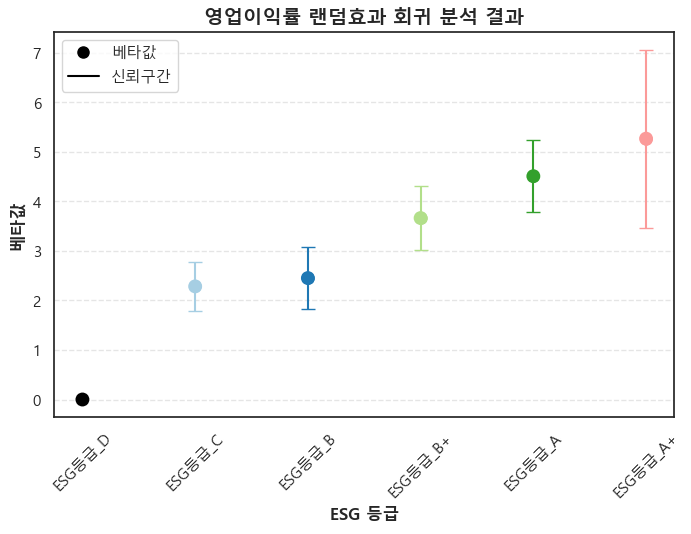

In [11]:
def plot_beta_values_beautiful(df, dep_var, what='랜덤'):
    df_filtered = df[df["종속변수"] == dep_var].copy()

    # ✅ X축 순서를 변경하여 ESG등급_D를 맨 왼쪽에 배치
    custom_order = ["ESG등급_D", "ESG등급_C", "ESG등급_B", "ESG등급_B+", "ESG등급_A", "ESG등급_A+"]
    df_filtered["독립변수"] = pd.Categorical(df_filtered["독립변수"], categories=custom_order, ordered=True)
    df_filtered = df_filtered.sort_values("독립변수")  # 올바르게 정렬

    # ✅ Seaborn 스타일 & 한글 폰트 설정
    sns.set_theme(font="Malgun Gothic", style="white", rc={"axes.unicode_minus": False})

    # ✅ 시각화 스타일 설정
    plt.figure(figsize=(8, 5))

    # ✅ 색상 설정 (ESG등급_D 제외)
    colors = sns.color_palette("Paired", len(custom_order) - 1)
    color_dict = dict(zip(custom_order[1:], colors))  # ESG등급_D는 제외

    # ✅ X축 위치 지정 (X축 간격 고정)
    x_positions = {category: i for i, category in enumerate(custom_order)}

    # ✅ 베타값 플롯 (ESG_D는 제외하고 표시)
    for i, row in df_filtered.iterrows():
        if row["독립변수"] != "ESG등급_D":  # ESG_D는 에러바 제외
            x_pos = x_positions[row["독립변수"]]
            color = color_dict.get(row["독립변수"], "none")
            plt.errorbar(x=x_pos, y=row["베타값"], 
                         yerr=[[row["베타값"] - row["Lower CI"]], [row["Upper CI"] - row["베타값"]]], 
                         fmt='o', color=color, capsize=5, markersize=8, label="_nolegend_")

    # ✅ 점 그래프 추가 (ESG_D 포함)
    for category in custom_order:
        x_pos = x_positions[category]
        if category == "ESG등급_D":
            plt.scatter(x_pos, 0, color="black", s=100, edgecolors="none")  # ESG_D는 검은색
        else:
            plt.scatter(x_pos, df_filtered[df_filtered["독립변수"] == category]["베타값"], 
                        color=color_dict[category], s=100, edgecolors="none")

    # ✅ 세로축 grid 추가 (연하게 설정)
    plt.grid(axis='y', linestyle='dashed', alpha=0.5)
    
    # ✅ X축을 강제로 ESG_D가 왼쪽으로 오도록 수동 정렬
    plt.xticks(range(len(custom_order)), custom_order, rotation=45)

    # ✅ Legend에서 ESG등급_D 제거 (베타값과 신뢰구간만 유지)
    legend_elements = [
        Line2D([0], [0], marker='o', color='black', markersize=8, linestyle='None', label="베타값"),
        Line2D([0], [0], color='black', lw=1.5, label="신뢰구간")
    ]
    plt.legend(handles=legend_elements, title=None)

    # ✅ 그래프 설정
    plt.xlabel("ESG 등급", fontsize=12, fontweight="bold")
    plt.ylabel("베타값", fontsize=12, fontweight="bold")
    plt.title(f"{dep_var} {what}효과 회귀 분석 결과", fontsize=14, fontweight="bold")

    plt.show()

# ✅ 특정 종속변수 예제 (예: '영업이익률')
plot_beta_values_beautiful(beta_df, "영업이익률")

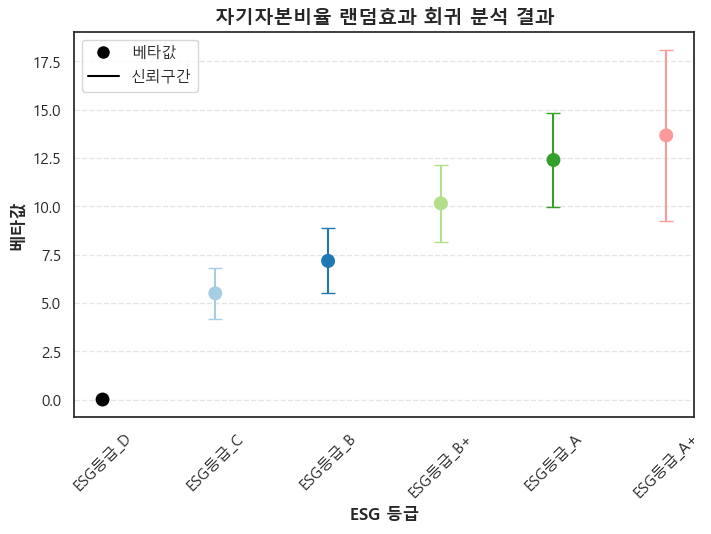

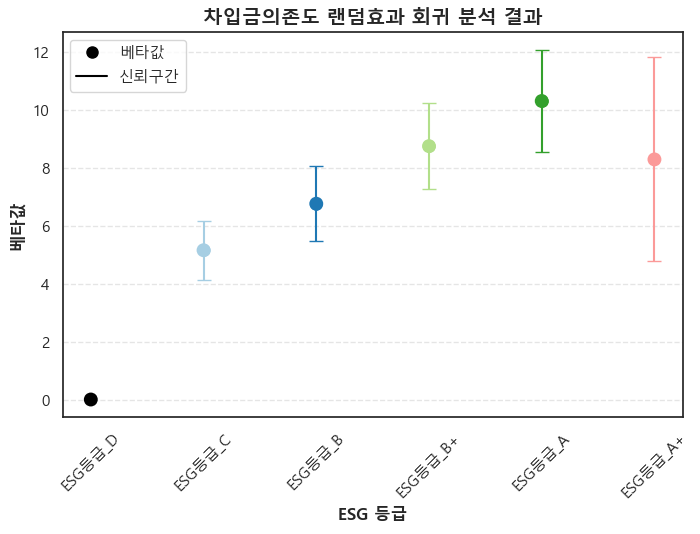

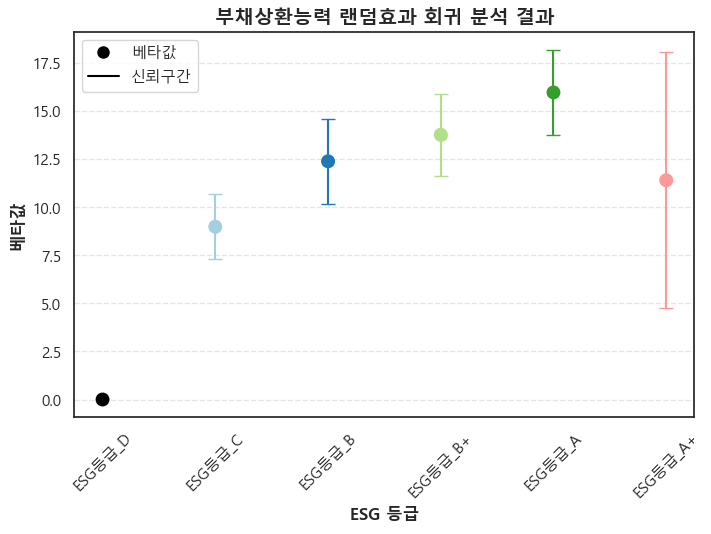

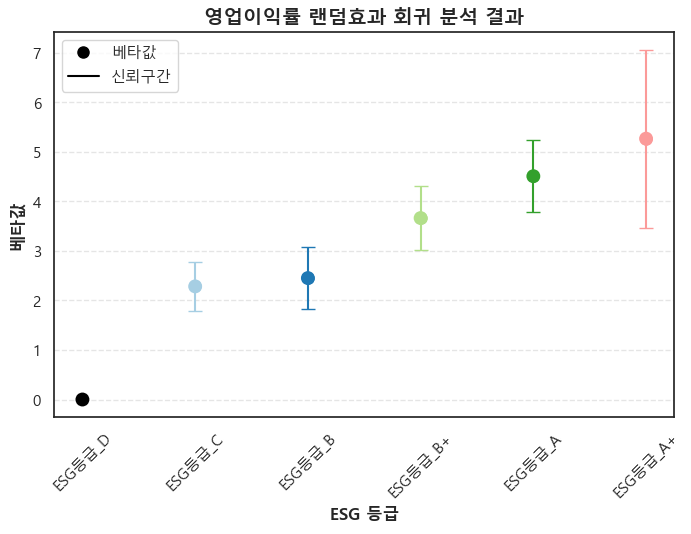

In [12]:
plot_beta_values_beautiful(beta_df, "자기자본비율")
plot_beta_values_beautiful(beta_df, "차입금의존도")
plot_beta_values_beautiful(beta_df, "부채상환능력")
plot_beta_values_beautiful(beta_df, "영업이익률")

# shift 고정효과 시각화

In [13]:
# ✅ 베타값, 신뢰구간 추출 및 데이터프레임 생성
beta_results = []

for dep_var, result in fe_results_list1:
    for param in independent_vars:
        coef = result.params[param]  # 베타값
        std_err = result.std_errors[param]  # 표준오차
        lower_ci = coef - 1.96 * std_err  # 95% 신뢰구간 하한
        upper_ci = coef + 1.96 * std_err  # 95% 신뢰구간 상한
        
        beta_results.append({
            "종속변수": dep_var,
            "독립변수": param,
            "베타값": coef,
            "Lower CI": lower_ci,
            "Upper CI": upper_ci
        })

# ✅ 데이터프레임 변환
beta_df = pd.DataFrame(beta_results)
beta_df

,종속변수,독립변수,베타값,Lower CI,Upper CI
0,매출액증가율,ESG등급_A,4.867240,-1.479017,11.213497
1,매출액증가율,ESG등급_A+,11.890440,1.564576,22.216304
2,매출액증가율,ESG등급_B,1.532559,-2.840839,5.905957
3,매출액증가율,ESG등급_B+,3.588987,-1.536998,8.714972
4,매출액증가율,ESG등급_C,-2.082306,-5.196516,1.031904
5,총자본회전율,ESG등급_A,-6.580821,-18.983588,5.821947
6,총자본회전율,ESG등급_A+,5.492203,-14.688085,25.672492
7,총자본회전율,ESG등급_B,2.790137,-5.756987,11.337260
8,총자본회전율,ESG등급_B+,-6.929228,-16.947165,3.088710
9,총자본회전율,ESG등급_C,-3.041206,-9.127443,3.045031


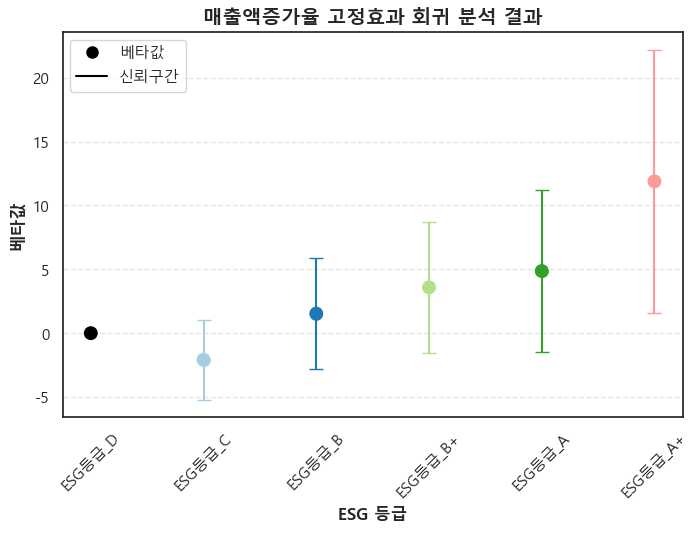

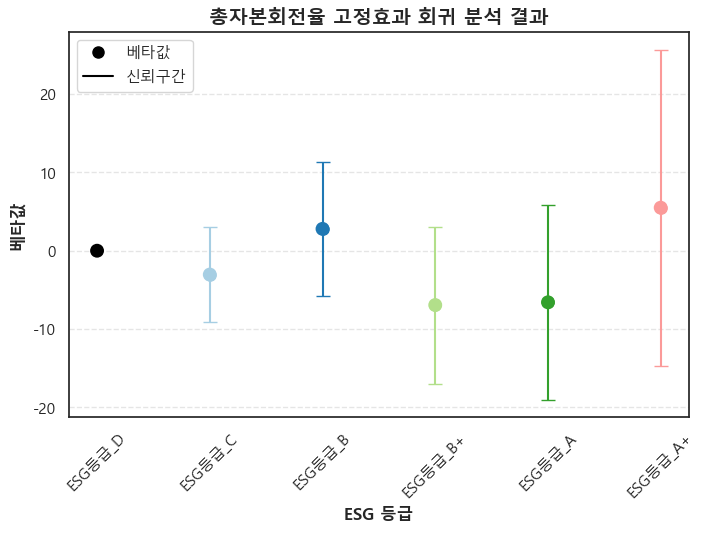

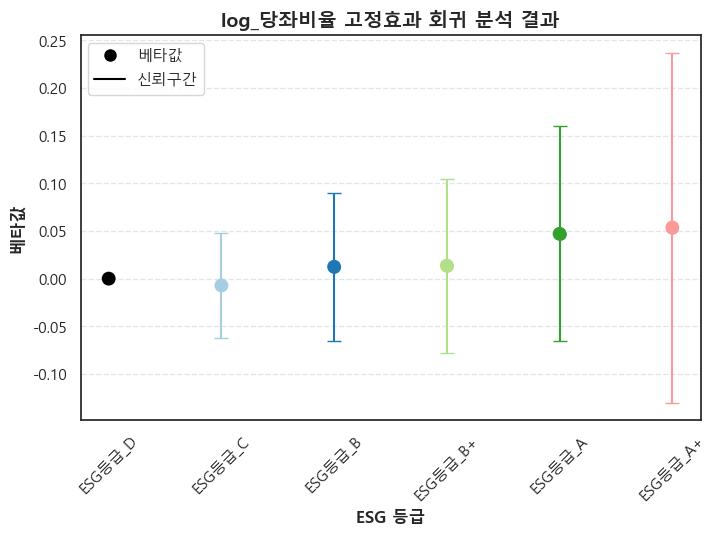

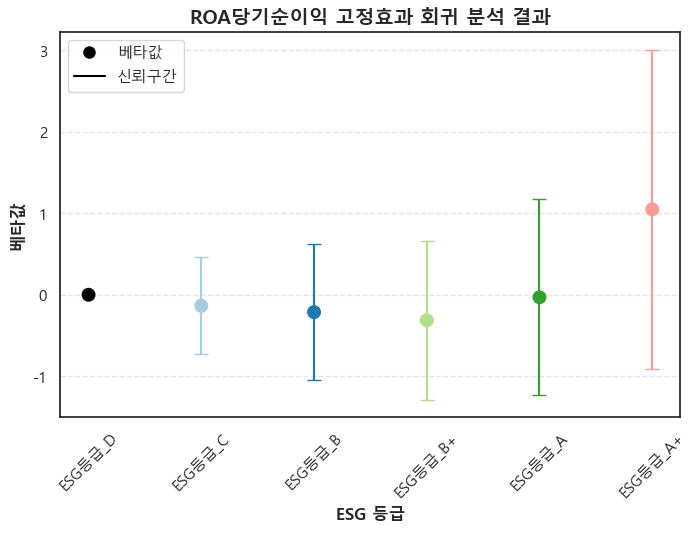

In [14]:
plot_beta_values_beautiful(beta_df, "매출액증가율", '고정')
plot_beta_values_beautiful(beta_df, "총자본회전율", '고정')
plot_beta_values_beautiful(beta_df, "log_당좌비율", '고정')
plot_beta_values_beautiful(beta_df, "ROA당기순이익", '고정')

# NOT SHIFTED + 고정효과 시각화

In [15]:
df = pd.read_csv("IQR1.5_log_scaling.csv")#, index_col=0)
#df = df.drop(columns=['Unnamed: 0'])
df.columns = [re.sub(r"[()% ]", "", col) for col in df.columns]

In [16]:
# 스케일링2

df_transformed = df.copy()

# 패널 데이터 구조 설정 (기업명과 연도를 MultiIndex로 설정)
df_transformed_h = df_transformed.set_index(["Name", "회계년"])

# ESG 등급의 원핫 인코딩 변수 리스트 추출
esg_variables = [col for col in df_transformed_h.columns if col.startswith("ESG등급_")]
# 종속변수 리스트
dependent_vars = ["자기자본비율", "차입금의존도", "매출액증가율",
                  "영업이익률", "총자본회전율", "부채상환능력",
                  "log_당좌비율", "ROA당기순이익"]

# 결과 저장을 위한 리스트
results = {}

for dep_var in dependent_vars:
    # 패널 회귀 모델 (고정효과 모델)
    X = df_transformed_h[esg_variables]  # 독립변수: ESG 원핫 인코딩 변수
    X = sm.add_constant(X)
    y = df_transformed_h[dep_var]  # 종속변수

    # 고정효과 모형
    model_fe = PanelOLS(y, X, entity_effects=True, time_effects=True)
    fe_res = model_fe.fit()

    # 랜덤효과 모형
    model_re = RandomEffects(y, X)
    re_res = model_re.fit()

    # 하우스만 검정 수행
    b_diff = fe_res.params - re_res.params
    v_diff = fe_res.cov - re_res.cov
    chi2_stat = b_diff.T @ np.linalg.inv(v_diff) @ b_diff
    p_value = 1 - stats.chi2.cdf(chi2_stat, df=len(b_diff))

    # 선택된 모델 결정
    selected_model = "Fixed Effects" if p_value < 0.05 else "Random Effects"

    # 결과 저장
    results[dep_var] = {"Hausman Test p-value": p_value, "Selected Model": selected_model}

# 결과출력
results_df = pd.DataFrame(results).T
results_df

,Hausman Test p-value,Selected Model
자기자본비율,0.465469,Random Effects
차입금의존도,0.288423,Random Effects
매출액증가율,0.001885,Fixed Effects
영업이익률,0.001265,Fixed Effects
총자본회전율,0.0,Fixed Effects
부채상환능력,0.763339,Random Effects
log_당좌비율,0.000003,Fixed Effects
ROA당기순이익,0.00843,Fixed Effects


In [17]:
# 패널 데이터 형식으로 변환
df_transformed_pf = df_transformed.set_index(["Name", "회계년"])  # 기업 ID와 연도를 기준으로 패널 데이터 설정

# 종속변수 목록
dependent_vars = ["매출액증가율", "영업이익률", "총자본회전율", "log_당좌비율", "ROA당기순이익"]

# 독립변수: ESG 등급 (다중공선성 방지를 위해 하나의 등급 제거된 상태여야 함)
independent_vars = [col for col in df_transformed_pf.columns if col.startswith("ESG등급_")]

# 분석 결과 저장용 리스트
fe_results_list1 = []

for dep_var in dependent_vars:
    # 종속변수와 독립변수 설정
    y = df_transformed_pf[dep_var]
    X = df_transformed_pf[independent_vars]

    # 고정효과 모형 (패널 OLS)
    model_fe = PanelOLS(y,X, entity_effects=True, time_effects=True)
    fe_results = model_fe.fit()

    # 결과 저장
    fe_results_list1.append((dep_var, fe_results))

    # 각 변수별 결과 출력
    print(f"=== {dep_var} 고정효과 모델 결과 ===")
    print(fe_results)
    print("\n" + "=" * 50 + "\n")

# 분석 결과를 데이터프레임으로 정리하여 확인
summary_data = {
    "종속변수": [],
    "R-squared": [],
    "Adj. R-squared": [],
    "F-statistic": [],
    "p-value": []
}

for dep_var, result in fe_results_list1:
    summary_data["종속변수"].append(dep_var)
    summary_data["R-squared"].append(result.rsquared)
    summary_data["Adj. R-squared"].append(result.rsquared_within)
    summary_data["F-statistic"].append(result.f_statistic.stat if result.f_statistic else None)
    summary_data["p-value"].append(result.f_statistic.pval if result.f_statistic else None)

summary_df3 = pd.DataFrame(summary_data)

=== 매출액증가율 고정효과 모델 결과 ===
                          PanelOLS Estimation Summary                           
Dep. Variable:                 매출액증가율   R-squared:                        0.0122
Estimator:                   PanelOLS   R-squared (Between):              0.0270
No. Observations:                1533   R-squared (Within):               0.0053
Date:                Sun, Feb 16 2025   R-squared (Overall):              0.0158
Time:                        18:02:52   Log-likelihood                   -5988.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2.5326
Entities:                         502   P-value                           0.0274
Avg Obs:                       3.0538   Distribution:                  F(5,1023)
Min Obs:                       1.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             2.5326
  

In [18]:
# 패널 데이터 형식으로 변환
df_transformed_pf = df_transformed.set_index(["Name", "회계년"])  # 기업 ID와 연도를 기준으로 패널 데이터 설정

# 종속변수 목록 (원하는 변수로 설정)
dependent_vars_re = ["자기자본비율", "차입금의존도", "부채상환능력"]  # 여기에 원하는 종속변수 입력

# 독립변수: ESG 등급 (다중공선성 방지를 위해 하나의 등급 제거된 상태여야 함)
independent_vars = [col for col in df_transformed_pf.columns if col.startswith("ESG등급_")]

# 분석 결과 저장용 리스트
re_results_list2 = []

for dep_var in dependent_vars_re:
    # 종속변수와 독립변수 설정
    y = df_transformed_pf[dep_var]
    X = df_transformed_pf[independent_vars]

    # 랜덤효과 모형 (패널 GLS)
    model_re = RandomEffects(y, X)
    re_results = model_re.fit()

    # 결과 저장
    re_results_list2.append((dep_var, re_results))

    # 각 변수별 결과 출력
    print(f"=== {dep_var} 랜덤효과 모델 결과 ===")
    print(re_results)
    print("\n" + "=" * 50 + "\n")

# 분석 결과를 데이터프레임으로 정리하여 확인
summary_data_re = {
    "종속변수": [],
    "R-squared": [],
    "Adj. R-squared": [],
    "F-statistic": [],
    "p-value": []
}

for dep_var, result in re_results_list2:
    summary_data_re["종속변수"].append(dep_var)
    summary_data_re["R-squared"].append(result.rsquared)
    summary_data_re["Adj. R-squared"].append(result.rsquared_within)
    summary_data_re["F-statistic"].append(result.f_statistic.stat if result.f_statistic else None)
    summary_data_re["p-value"].append(result.f_statistic.pval if result.f_statistic else None)

summary_df_re = pd.DataFrame(summary_data_re)


=== 자기자본비율 랜덤효과 모델 결과 ===
                        RandomEffects Estimation Summary                        
Dep. Variable:                 자기자본비율   R-squared:                        0.1046
Estimator:              RandomEffects   R-squared (Between):              0.2397
No. Observations:                1533   R-squared (Within):              -0.2870
Date:                Sun, Feb 16 2025   R-squared (Overall):              0.2457
Time:                        18:02:52   Log-likelihood                   -5252.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      35.683
Entities:                         502   P-value                           0.0000
Avg Obs:                       3.0538   Distribution:                  F(5,1528)
Min Obs:                       1.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             35.683
  

In [19]:
# ✅ 베타값, 신뢰구간 추출 및 데이터프레임 생성
beta_results = []

for dep_var, result in fe_results_list1:
    for param in independent_vars:
        coef = result.params[param]  # 베타값
        std_err = result.std_errors[param]  # 표준오차
        lower_ci = coef - 1.96 * std_err  # 95% 신뢰구간 하한
        upper_ci = coef + 1.96 * std_err  # 95% 신뢰구간 상한
        
        beta_results.append({
            "종속변수": dep_var,
            "독립변수": param,
            "베타값": coef,
            "Lower CI": lower_ci,
            "Upper CI": upper_ci
        })

# ✅ 데이터프레임 변환
beta_df = pd.DataFrame(beta_results)
beta_df

,종속변수,독립변수,베타값,Lower CI,Upper CI
0,매출액증가율,ESG등급_A,-2.437770,-8.482288,3.606749
1,매출액증가율,ESG등급_A+,-15.190510,-26.433803,-3.947218
2,매출액증가율,ESG등급_B,2.327591,-1.682812,6.337994
3,매출액증가율,ESG등급_B+,0.847265,-4.005574,5.700104
4,매출액증가율,ESG등급_C,1.915463,-1.199431,5.030357
5,영업이익률,ESG등급_A,-1.591414,-2.832829,-0.349999
6,영업이익률,ESG등급_A+,-1.310672,-3.619804,0.998461
7,영업이익률,ESG등급_B,-0.656628,-1.480279,0.167023
8,영업이익률,ESG등급_B+,-0.959321,-1.955990,0.037349
9,영업이익률,ESG등급_C,-0.773043,-1.412776,-0.133310


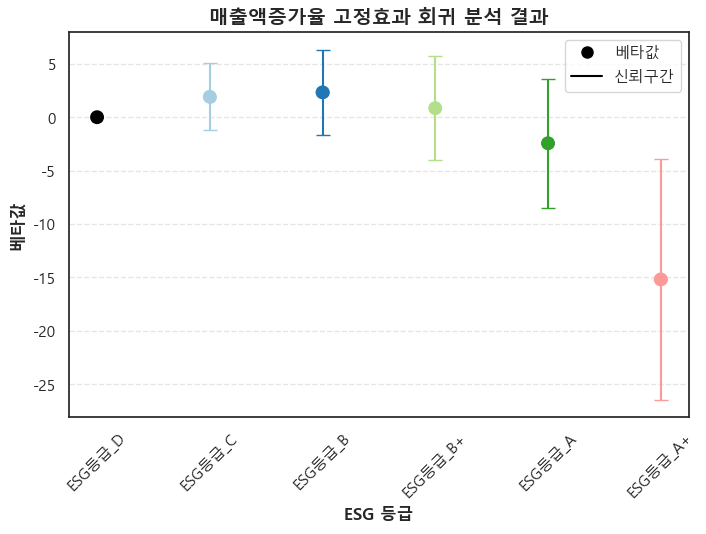

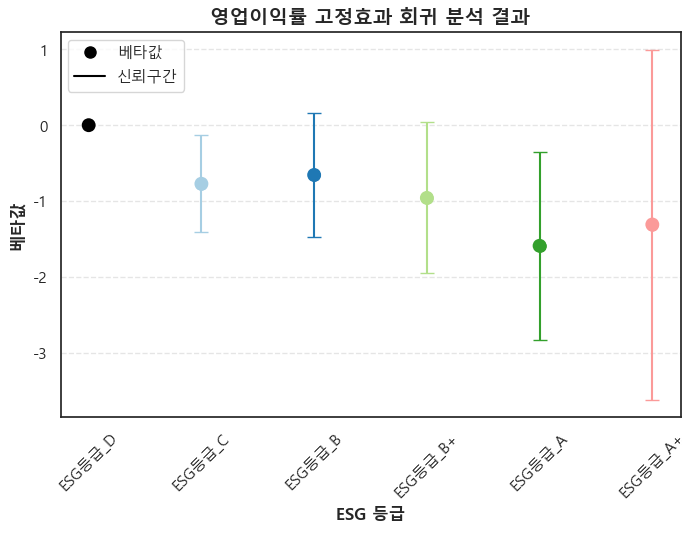

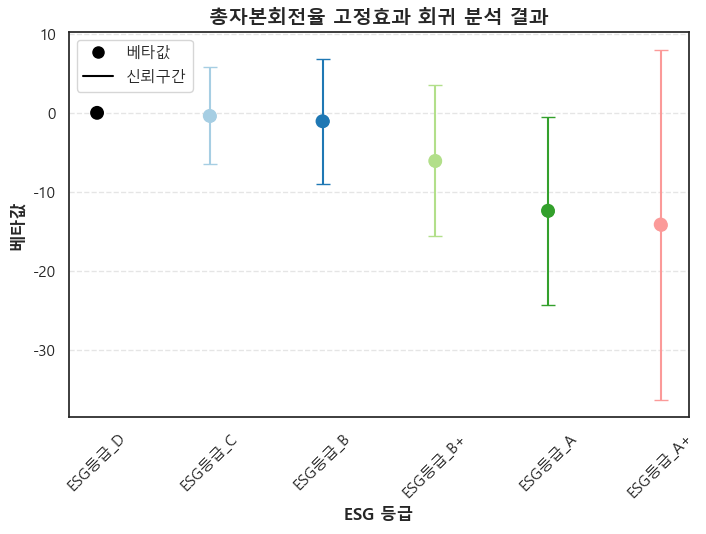

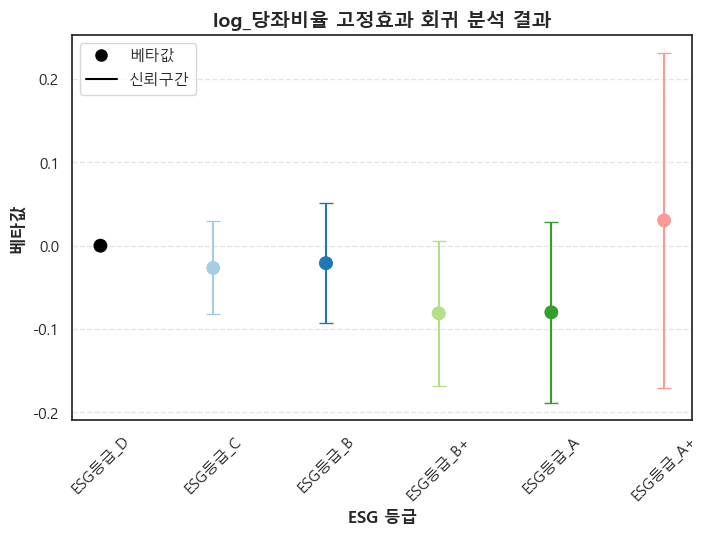

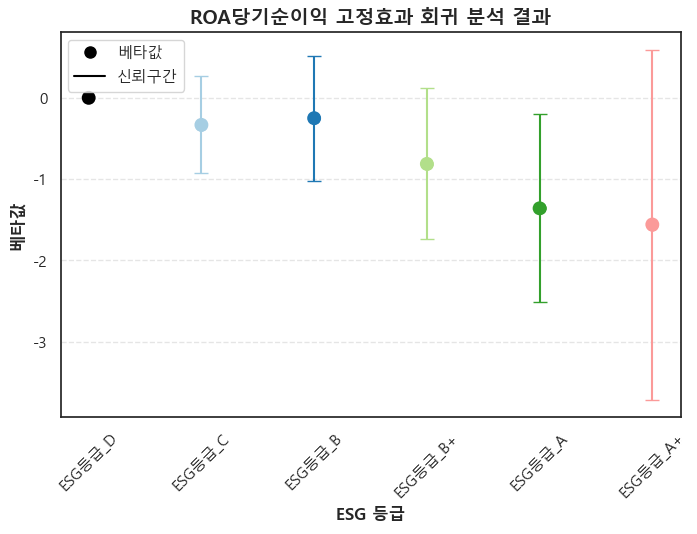

In [20]:
plot_beta_values_beautiful(beta_df, "매출액증가율", "고정")
plot_beta_values_beautiful(beta_df, "영업이익률", "고정")
plot_beta_values_beautiful(beta_df, "총자본회전율", "고정")
plot_beta_values_beautiful(beta_df, "log_당좌비율", "고정")
plot_beta_values_beautiful(beta_df, "ROA당기순이익", "고정")

# NOT SHIFTED 랜덤효과 시각화

In [21]:
# ✅ 베타값, 신뢰구간 추출 및 데이터프레임 생성
beta_results = []

for dep_var, result in re_results_list2:
    for param in independent_vars:
        coef = result.params[param]  # 베타값
        std_err = result.std_errors[param]  # 표준오차
        lower_ci = coef - 1.96 * std_err  # 95% 신뢰구간 하한
        upper_ci = coef + 1.96 * std_err  # 95% 신뢰구간 상한
        
        beta_results.append({
            "종속변수": dep_var,
            "독립변수": param,
            "베타값": coef,
            "Lower CI": lower_ci,
            "Upper CI": upper_ci
        })

# ✅ 데이터프레임 변환
beta_df = pd.DataFrame(beta_results)
beta_df

,종속변수,독립변수,베타값,Lower CI,Upper CI
0,자기자본비율,ESG등급_A,13.642929,11.116551,16.169307
1,자기자본비율,ESG등급_A+,15.302792,9.962334,20.643249
2,자기자본비율,ESG등급_B,8.837459,7.227225,10.447693
3,자기자본비율,ESG등급_B+,11.455551,9.410026,13.501076
4,자기자본비율,ESG등급_C,7.408173,6.016277,8.800069
5,차입금의존도,ESG등급_A,10.376342,8.555076,12.197608
6,차입금의존도,ESG등급_A+,12.228054,8.106862,16.349245
7,차입금의존도,ESG등급_B,6.464355,5.263918,7.664793
8,차입금의존도,ESG등급_B+,9.357718,7.872529,10.842908
9,차입금의존도,ESG등급_C,5.176716,4.131538,6.221894


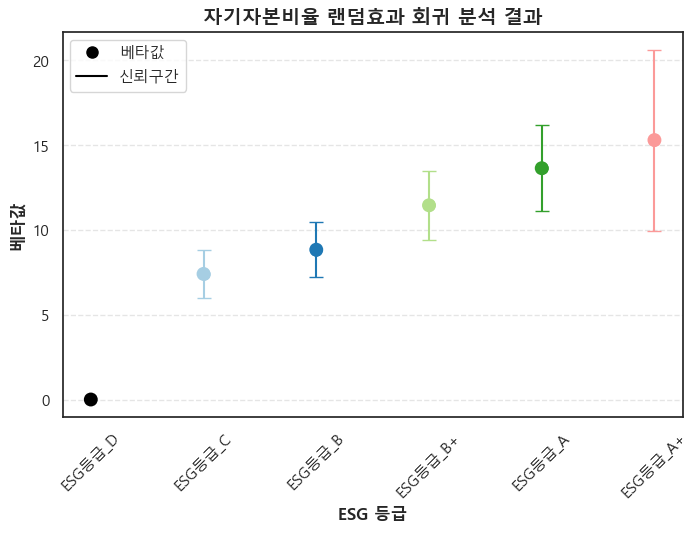

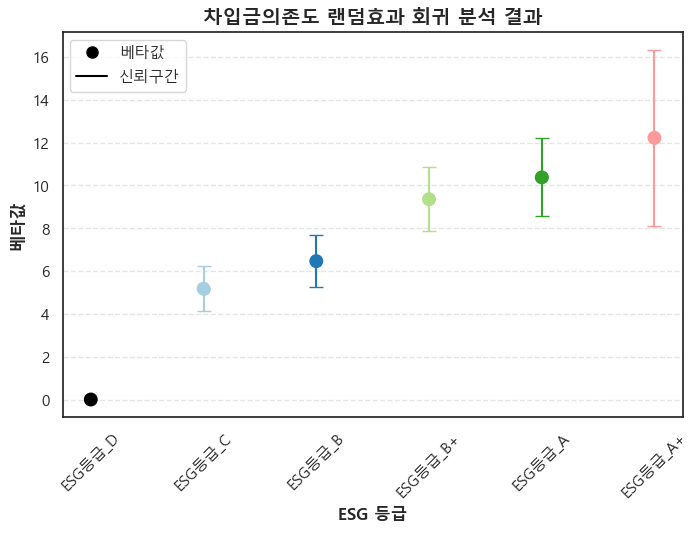

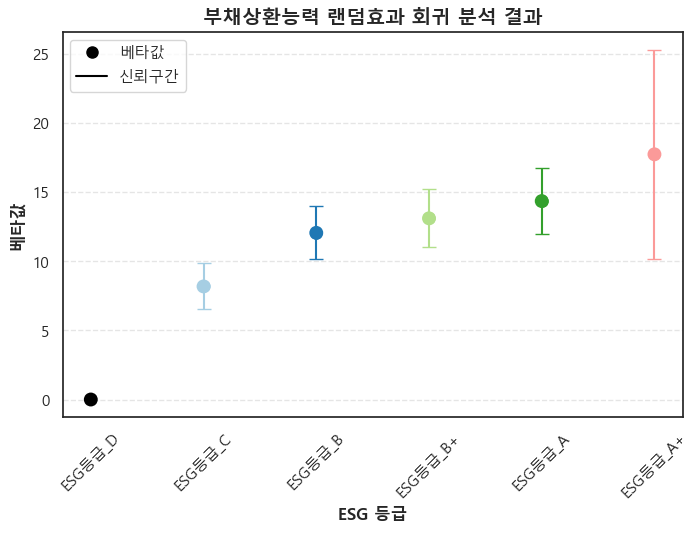

In [22]:
plot_beta_values_beautiful(beta_df, "자기자본비율")
plot_beta_values_beautiful(beta_df, "차입금의존도")
plot_beta_values_beautiful(beta_df, "부채상환능력")

# ESG 따로 / NOT SHIFTED + 고정효과 시각화

In [23]:
df = pd.read_csv("IQR1.5_log_scaling.csv")#, index_col=0)
#df = df.drop(columns=['Unnamed: 0'])
df.columns = [re.sub(r"[()% ]", "", col) for col in df.columns]

In [24]:
# 스케일링2

df_transformed = df.copy()

# 패널 데이터 구조 설정 (기업명과 연도를 MultiIndex로 설정)
df_transformed_h = df_transformed.set_index(["Name", "회계년"])

# ESG 등급의 원핫 인코딩 변수 리스트 추출
esg_variables = [col for col in df_transformed_h.columns if col.startswith(("환경_", "사회_", "지배구조_"))]
# 종속변수 리스트
dependent_vars = ["자기자본비율", "차입금의존도", "매출액증가율",
                  "영업이익률", "총자본회전율", "부채상환능력",
                  "log_당좌비율", "ROA당기순이익"]

# 결과 저장을 위한 리스트
results = {}

for dep_var in dependent_vars:
    # 패널 회귀 모델 (고정효과 모델)
    X = df_transformed_h[esg_variables]  # 독립변수: ESG 원핫 인코딩 변수
    X = sm.add_constant(X)
    y = df_transformed_h[dep_var]  # 종속변수

    # 고정효과 모형
    model_fe = PanelOLS(y, X, entity_effects=True, time_effects=True)
    fe_res = model_fe.fit()

    # 랜덤효과 모형
    model_re = RandomEffects(y, X)
    re_res = model_re.fit()

    # 하우스만 검정 수행
    b_diff = fe_res.params - re_res.params
    v_diff = fe_res.cov - re_res.cov
    chi2_stat = b_diff.T @ np.linalg.inv(v_diff) @ b_diff
    p_value = 1 - stats.chi2.cdf(chi2_stat, df=len(b_diff))

    # 선택된 모델 결정
    selected_model = "Fixed Effects" if p_value < 0.05 else "Random Effects"

    # 결과 저장
    results[dep_var] = {"Hausman Test p-value": p_value, "Selected Model": selected_model}

# 결과출력
results_df = pd.DataFrame(results).T
results_df

,Hausman Test p-value,Selected Model
자기자본비율,0.215642,Random Effects
차입금의존도,0.447946,Random Effects
매출액증가율,0.0,Fixed Effects
영업이익률,0.000095,Fixed Effects
총자본회전율,0.0,Fixed Effects
부채상환능력,0.013431,Fixed Effects
log_당좌비율,0.002688,Fixed Effects
ROA당기순이익,0.000138,Fixed Effects


In [25]:
# 패널 데이터 형식으로 변환
df_transformed_pf = df_transformed.set_index(["Name", "회계년"])  # 기업 ID와 연도를 기준으로 패널 데이터 설정

# 종속변수 목록
dependent_vars = ["매출액증가율", "영업이익률", "총자본회전율", "부채상환능력", "log_당좌비율", "ROA당기순이익"]

# 독립변수: ESG 등급 (다중공선성 방지를 위해 하나의 등급 제거된 상태여야 함)
independent_vars = [col for col in df_transformed_h.columns if col.startswith(("환경_", "사회_", "지배구조_"))]

# 분석 결과 저장용 리스트
fe_results_list1 = []

for dep_var in dependent_vars:
    # 종속변수와 독립변수 설정
    y = df_transformed_pf[dep_var]
    X = df_transformed_pf[independent_vars]

    # 고정효과 모형 (패널 OLS)
    model_fe = PanelOLS(y,X, entity_effects=True, time_effects=True)
    fe_results = model_fe.fit()

    # 결과 저장
    fe_results_list1.append((dep_var, fe_results))

    # 각 변수별 결과 출력
    print(f"=== {dep_var} 고정효과 모델 결과 ===")
    print(fe_results)
    print("\n" + "=" * 50 + "\n")

# 분석 결과를 데이터프레임으로 정리하여 확인
summary_data = {
    "종속변수": [],
    "R-squared": [],
    "Adj. R-squared": [],
    "F-statistic": [],
    "p-value": []
}

for dep_var, result in fe_results_list1:
    summary_data["종속변수"].append(dep_var)
    summary_data["R-squared"].append(result.rsquared)
    summary_data["Adj. R-squared"].append(result.rsquared_within)
    summary_data["F-statistic"].append(result.f_statistic.stat if result.f_statistic else None)
    summary_data["p-value"].append(result.f_statistic.pval if result.f_statistic else None)

summary_df3 = pd.DataFrame(summary_data)

=== 매출액증가율 고정효과 모델 결과 ===
                          PanelOLS Estimation Summary                           
Dep. Variable:                 매출액증가율   R-squared:                        0.0401
Estimator:                   PanelOLS   R-squared (Between):              0.1751
No. Observations:                1533   R-squared (Within):               0.0073
Date:                Sun, Feb 16 2025   R-squared (Overall):              0.0990
Time:                        18:02:55   Log-likelihood                   -5966.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2.8202
Entities:                         502   P-value                           0.0002
Avg Obs:                       3.0538   Distribution:                 F(15,1013)
Min Obs:                       1.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             2.8202
  

In [26]:
# ✅ 베타값, 신뢰구간 추출 및 데이터프레임 생성
beta_results = []

for dep_var, result in fe_results_list1:
    for param in independent_vars:
        coef = result.params[param]  # 베타값
        std_err = result.std_errors[param]  # 표준오차
        lower_ci = coef - 1.96 * std_err  # 95% 신뢰구간 하한
        upper_ci = coef + 1.96 * std_err  # 95% 신뢰구간 상한
        
        beta_results.append({
            "종속변수": dep_var,
            "독립변수": param,
            "베타값": coef,
            "Lower CI": lower_ci,
            "Upper CI": upper_ci
        })

# ✅ 데이터프레임 변환
beta_df = pd.DataFrame(beta_results)
beta_df

,종속변수,독립변수,베타값,Lower CI,Upper CI
0,매출액증가율,환경_A,-7.827291,-14.060662,-1.593921
1,매출액증가율,환경_A+,-15.863749,-24.757497,-6.970000
2,매출액증가율,환경_B,0.645784,-3.324422,4.615991
3,매출액증가율,환경_B+,-3.320079,-8.212826,1.572669
4,매출액증가율,환경_C,-1.468042,-4.680657,1.744573
...,...,...,...,...,...
85,ROA당기순이익,지배구조_A,0.024319,-1.130590,1.179228
86,ROA당기순이익,지배구조_A+,0.742293,-3.181234,4.665821
87,ROA당기순이익,지배구조_B,0.487886,-0.240448,1.216219
88,ROA당기순이익,지배구조_B+,0.510512,-0.361908,1.382931


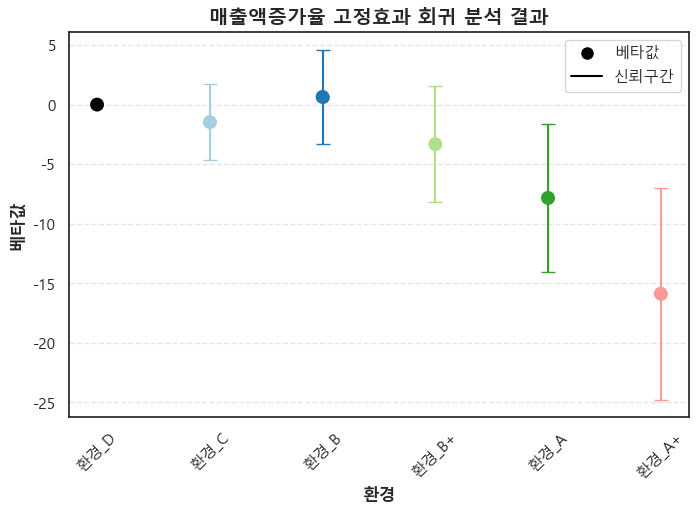

In [27]:

def plot_beta_values_beautiful(df, dep_var, model='랜덤', what='ESG등급'):
    df_filtered = df[df["종속변수"] == dep_var].copy()

    # ✅ NaN 값 제거 (독립변수 컬럼에서 NaN이 있는 행 삭제)
    df_filtered.dropna(subset=["독립변수"], inplace=True)

    # ✅ X축 순서 지정 (what을 기반으로 동적 변경)
    custom_order = [f"{what}_D", f"{what}_C", f"{what}_B", f"{what}_B+", f"{what}_A", f"{what}_A+"]
    df_filtered["독립변수"] = pd.Categorical(df_filtered["독립변수"], categories=custom_order, ordered=True)
    df_filtered = df_filtered.sort_values("독립변수")  # 올바르게 정렬

    # ✅ Seaborn 스타일 & 한글 폰트 설정
    sns.set_theme(font="Malgun Gothic", style="white", rc={"axes.unicode_minus": False})

    # ✅ 시각화 스타일 설정
    plt.figure(figsize=(8, 5))

    # ✅ 색상 설정 (what_D 제외)
    colors = sns.color_palette("Paired", len(custom_order) - 1)
    color_dict = dict(zip(custom_order[1:], colors))  # {what}_D는 제외

    # ✅ X축 위치 지정 (X축 간격 고정)
    x_positions = {category: i for i, category in enumerate(custom_order)}

    # ✅ 베타값 플롯 (D 등급 제외하고 표시)
    D = f"{what}_D"
    for i, row in df_filtered.iterrows():
        if pd.isna(row["독립변수"]):  # 🔥 NaN 값 건너뛰기
            continue
        if row["독립변수"] != D:  # {what}_D는 에러바 제외
            x_pos = x_positions[row["독립변수"]]
            color = color_dict.get(row["독립변수"], "none")
            plt.errorbar(x=x_pos, y=row["베타값"], 
                         yerr=[[row["베타값"] - row["Lower CI"]], [row["Upper CI"] - row["베타값"]]], 
                         fmt='o', color=color, capsize=5, markersize=8, label="_nolegend_")

    # ✅ 점 그래프 추가 (D 포함)
    for category in custom_order:
        x_pos = x_positions[category]
        if category == D:
            plt.scatter(x_pos, 0, color="black", s=100, edgecolors="none")  # D 등급은 검은색
        else:
            beta_value = df_filtered.loc[df_filtered["독립변수"] == category, "베타값"].values  # 안전한 값 선택
            if len(beta_value) > 0:  # 값이 존재할 경우만 scatter 추가
                plt.scatter(x_pos, beta_value[0], color=color_dict[category], s=100, edgecolors="none")

    # ✅ 세로축 grid 추가 (연하게 설정)
    plt.grid(axis='y', linestyle='dashed', alpha=0.5)
    
    # ✅ X축을 강제로 정렬
    plt.xticks(range(len(custom_order)), custom_order, rotation=45)

    # ✅ Legend에서 {what}_D 제거 (베타값과 신뢰구간만 유지)
    legend_elements = [
        Line2D([0], [0], marker='o', color='black', markersize=8, linestyle='None', label="베타값"),
        Line2D([0], [0], color='black', lw=1.5, label="신뢰구간")
    ]
    plt.legend(handles=legend_elements, title=None)

    # ✅ 그래프 설정
    plt.xlabel(f"{what}", fontsize=12, fontweight="bold")
    plt.ylabel("베타값", fontsize=12, fontweight="bold")
    plt.title(f"{dep_var} {model}효과 회귀 분석 결과", fontsize=14, fontweight="bold")

    plt.show()

# ✅ 특정 종속변수 예제 (예: '매출액증가율', X축을 "환경"으로 변경)
plot_beta_values_beautiful(beta_df, "매출액증가율", model="고정", what="환경")


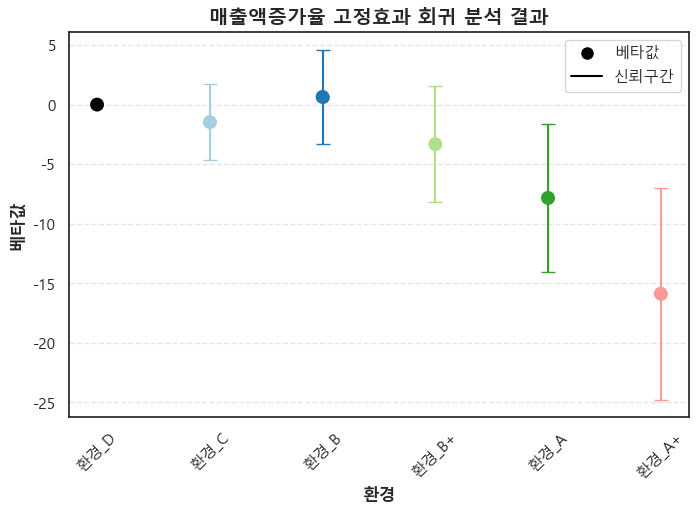

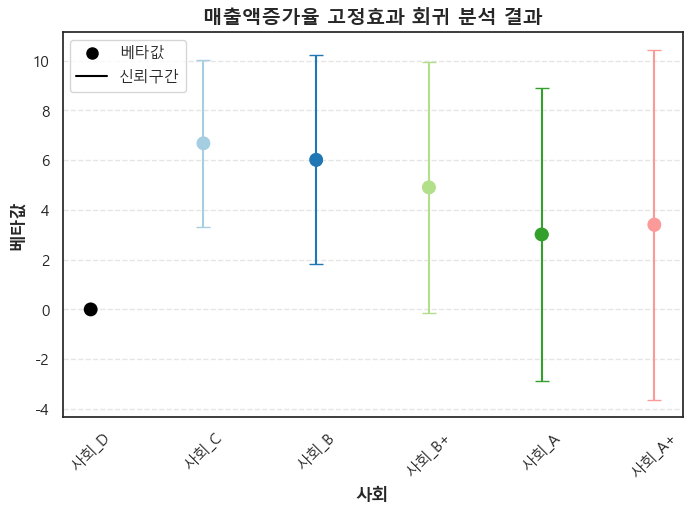

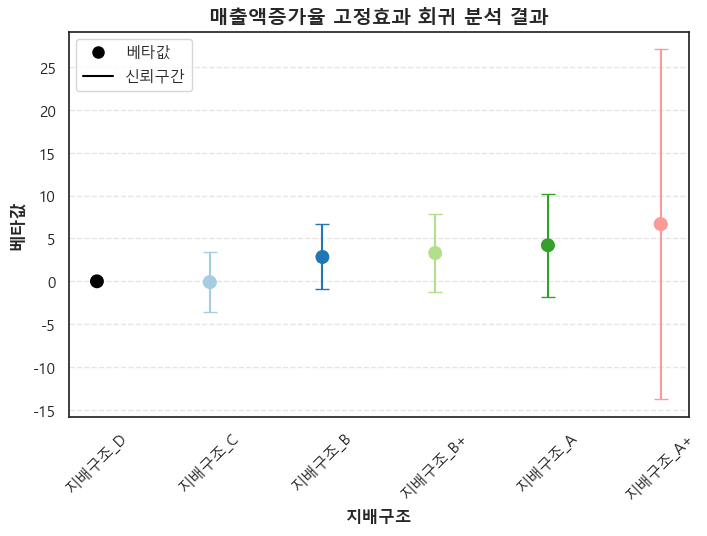

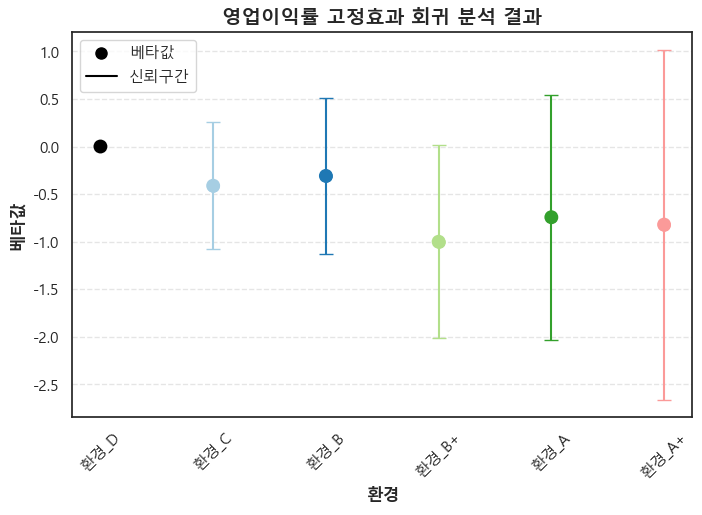

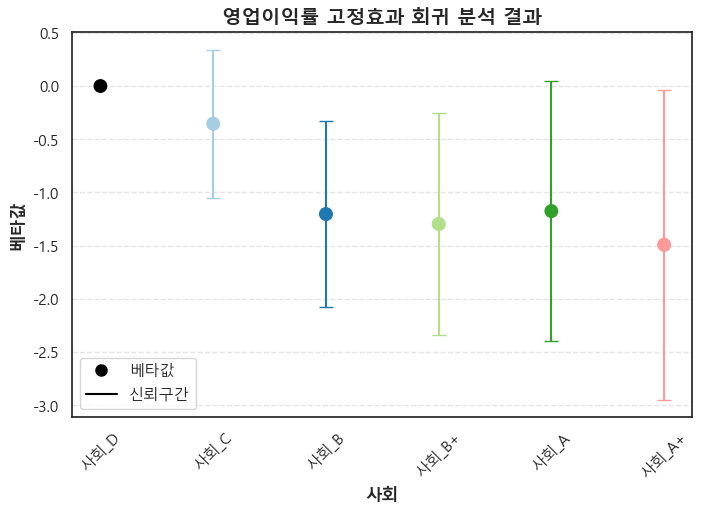

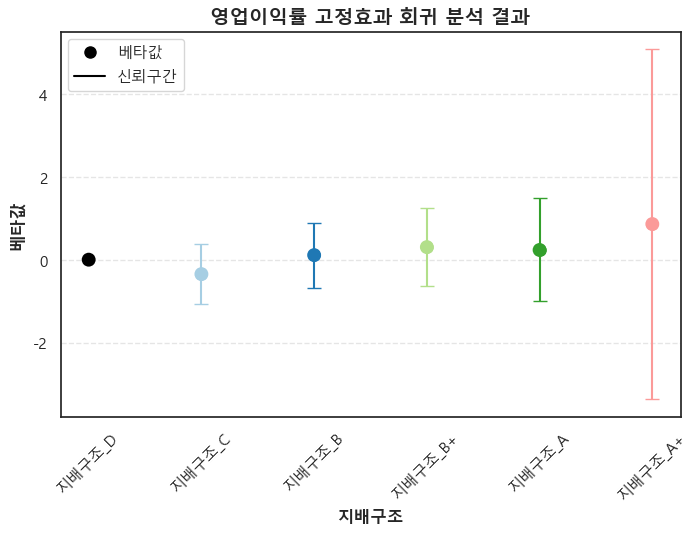

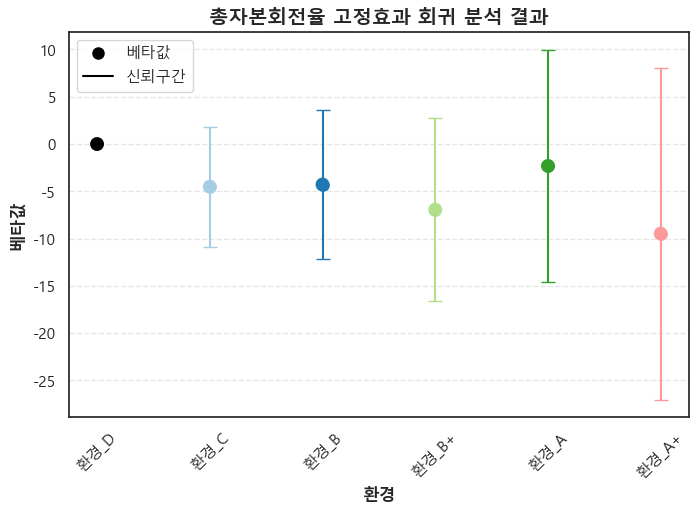

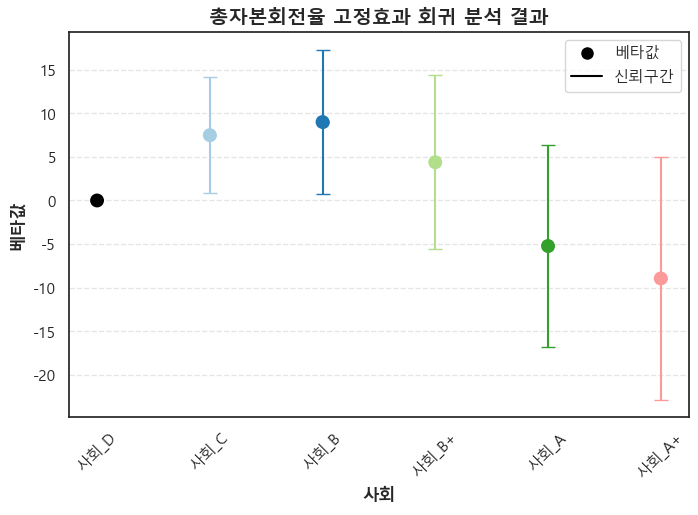

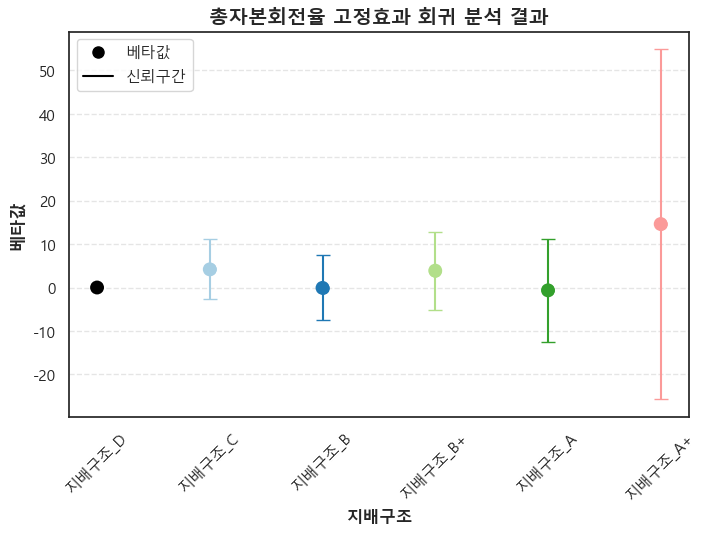

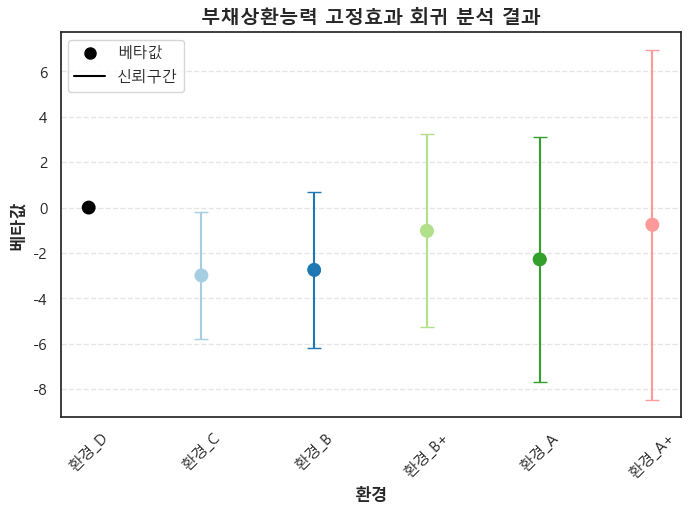

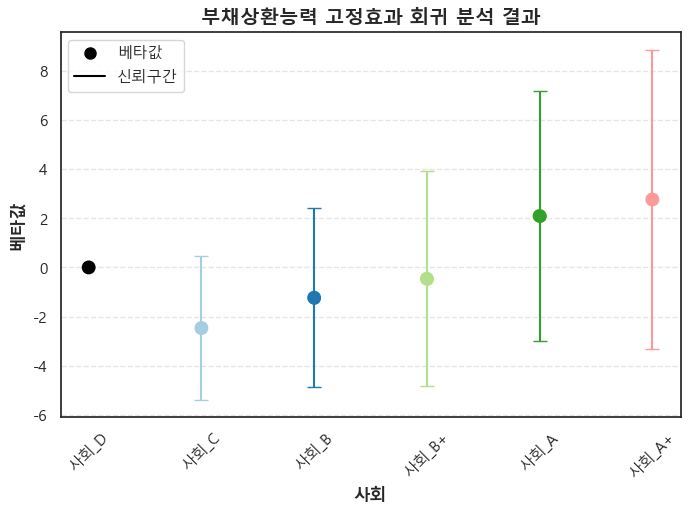

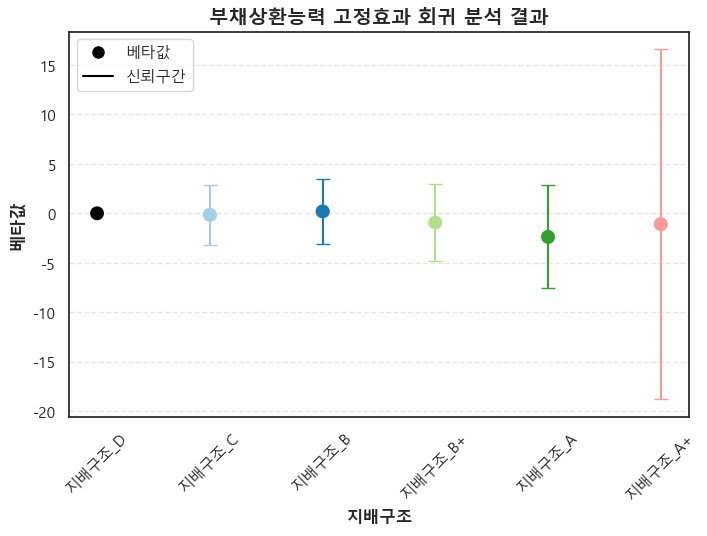

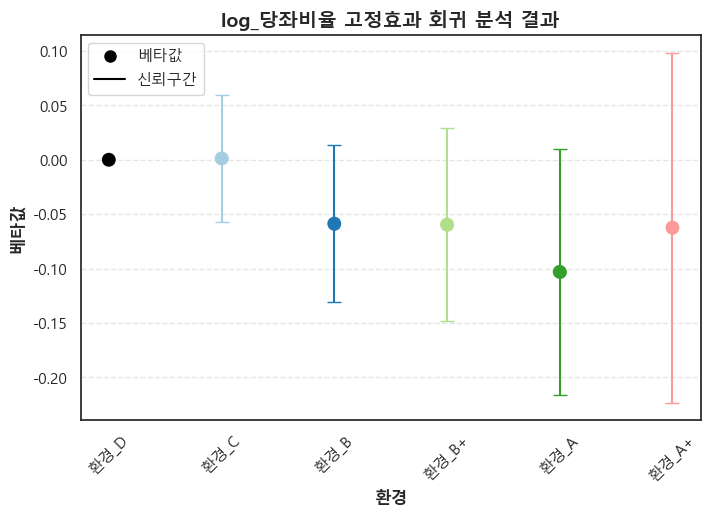

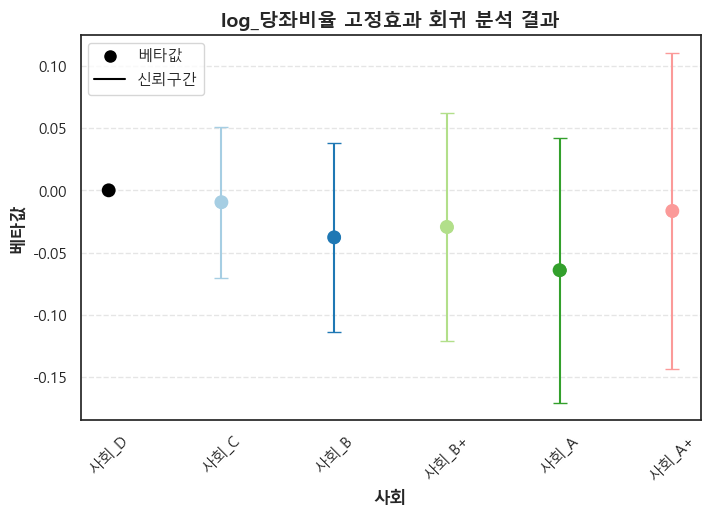

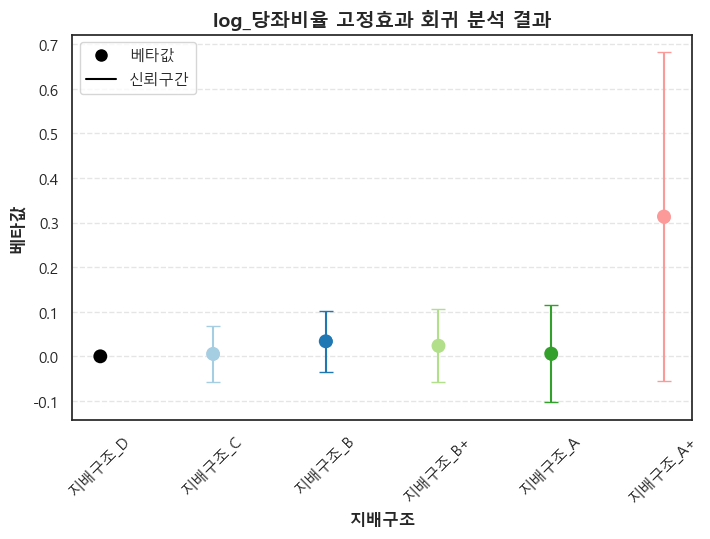

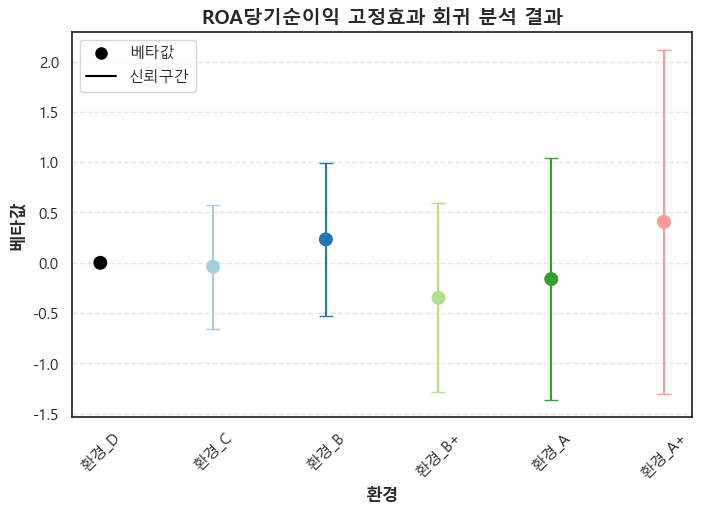

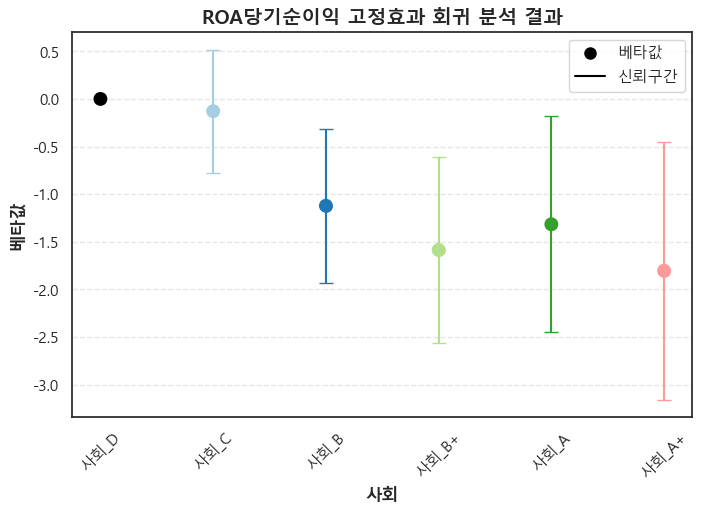

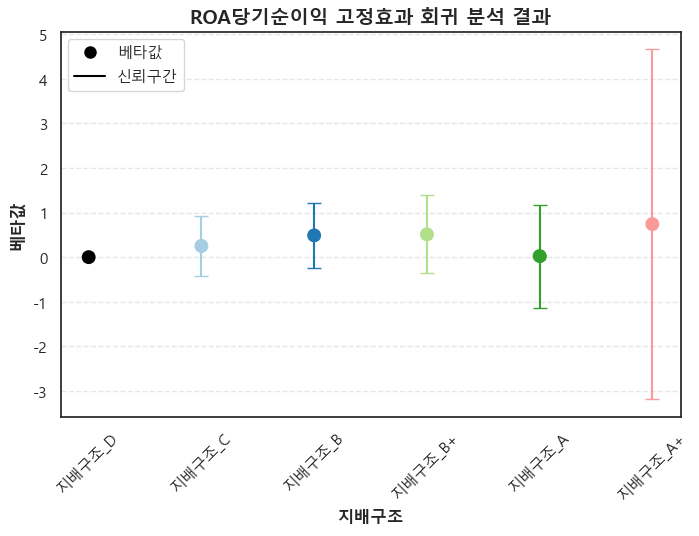

In [28]:
plot_beta_values_beautiful(beta_df, "매출액증가율", model="고정", what="환경")
plot_beta_values_beautiful(beta_df, "매출액증가율", model="고정", what="사회")
plot_beta_values_beautiful(beta_df, "매출액증가율", model="고정", what="지배구조")
plot_beta_values_beautiful(beta_df, "영업이익률", model="고정", what="환경")
plot_beta_values_beautiful(beta_df, "영업이익률", model="고정", what="사회")
plot_beta_values_beautiful(beta_df, "영업이익률", model="고정", what="지배구조")
plot_beta_values_beautiful(beta_df, "총자본회전율", model="고정", what="환경")
plot_beta_values_beautiful(beta_df, "총자본회전율", model="고정", what="사회")
plot_beta_values_beautiful(beta_df, "총자본회전율", model="고정", what="지배구조")
plot_beta_values_beautiful(beta_df, "부채상환능력", model="고정", what="환경")
plot_beta_values_beautiful(beta_df, "부채상환능력", model="고정", what="사회")
plot_beta_values_beautiful(beta_df, "부채상환능력", model="고정", what="지배구조")
plot_beta_values_beautiful(beta_df, "log_당좌비율", model="고정", what="환경")
plot_beta_values_beautiful(beta_df, "log_당좌비율", model="고정", what="사회")
plot_beta_values_beautiful(beta_df, "log_당좌비율", model="고정", what="지배구조")
plot_beta_values_beautiful(beta_df, "ROA당기순이익", model="고정", what="환경")
plot_beta_values_beautiful(beta_df, "ROA당기순이익", model="고정", what="사회")
plot_beta_values_beautiful(beta_df, "ROA당기순이익", model="고정", what="지배구조")

# ESG 따로 / NOT SHIFTED + 랜덤효과 시각화

In [29]:
# 패널 데이터 형식으로 변환
df_transformed_pf = df_transformed.set_index(["Name", "회계년"])  # 기업 ID와 연도를 기준으로 패널 데이터 설정

# 종속변수 목록 (원하는 변수로 설정)
dependent_vars_re = ["자기자본비율", "차입금의존도"]  # 여기에 원하는 종속변수 입력

# 독립변수: ESG 등급 (다중공선성 방지를 위해 하나의 등급 제거된 상태여야 함)
independent_vars = [col for col in df_transformed_h.columns if col.startswith(("환경_", "사회_", "지배구조_"))]

# 분석 결과 저장용 리스트
re_results_list2 = []

for dep_var in dependent_vars_re:
    # 종속변수와 독립변수 설정
    y = df_transformed_pf[dep_var]
    X = df_transformed_pf[independent_vars]

    # 랜덤효과 모형 (패널 GLS)
    model_re = RandomEffects(y, X)
    re_results = model_re.fit()

    # 결과 저장
    re_results_list2.append((dep_var, re_results))

    # 각 변수별 결과 출력
    print(f"=== {dep_var} 랜덤효과 모델 결과 ===")
    print(re_results)
    print("\n" + "=" * 50 + "\n")

# 분석 결과를 데이터프레임으로 정리하여 확인
summary_data_re = {
    "종속변수": [],
    "R-squared": [],
    "Adj. R-squared": [],
    "F-statistic": [],
    "p-value": []
}

for dep_var, result in re_results_list2:
    summary_data_re["종속변수"].append(dep_var)
    summary_data_re["R-squared"].append(result.rsquared)
    summary_data_re["Adj. R-squared"].append(result.rsquared_within)
    summary_data_re["F-statistic"].append(result.f_statistic.stat if result.f_statistic else None)
    summary_data_re["p-value"].append(result.f_statistic.pval if result.f_statistic else None)

summary_df_re = pd.DataFrame(summary_data_re)

=== 자기자본비율 랜덤효과 모델 결과 ===
                        RandomEffects Estimation Summary                        
Dep. Variable:                 자기자본비율   R-squared:                        0.2122
Estimator:              RandomEffects   R-squared (Between):              0.4293
No. Observations:                1533   R-squared (Within):              -0.6600
Date:                Sun, Feb 16 2025   R-squared (Overall):              0.4367
Time:                        18:03:00   Log-likelihood                   -5347.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      27.252
Entities:                         502   P-value                           0.0000
Avg Obs:                       3.0538   Distribution:                 F(15,1518)
Min Obs:                       1.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             27.252
  

In [30]:
# ✅ 베타값, 신뢰구간 추출 및 데이터프레임 생성
beta_results = []

for dep_var, result in re_results_list2:
    for param in independent_vars:
        coef = result.params[param]  # 베타값
        std_err = result.std_errors[param]  # 표준오차
        lower_ci = coef - 1.96 * std_err  # 95% 신뢰구간 하한
        upper_ci = coef + 1.96 * std_err  # 95% 신뢰구간 상한
        
        beta_results.append({
            "종속변수": dep_var,
            "독립변수": param,
            "베타값": coef,
            "Lower CI": lower_ci,
            "Upper CI": upper_ci
        })

# ✅ 데이터프레임 변환
beta_df = pd.DataFrame(beta_results)
beta_df

,종속변수,독립변수,베타값,Lower CI,Upper CI
0,자기자본비율,환경_A,5.354933,2.233196,8.476671
1,자기자본비율,환경_A+,7.063803,2.575504,11.552101
2,자기자본비율,환경_B,3.857737,1.806043,5.909431
3,자기자본비율,환경_B+,4.817533,2.324327,7.310739
4,자기자본비율,환경_C,4.603957,2.959873,6.248040
5,자기자본비율,사회_A,10.423076,7.359021,13.487131
6,자기자본비율,사회_A+,10.691284,7.008499,14.374069
7,자기자본비율,사회_B,5.268546,3.148987,7.388104
8,자기자본비율,사회_B+,8.553811,5.972223,11.135400
9,자기자본비율,사회_C,5.303314,3.568297,7.038331


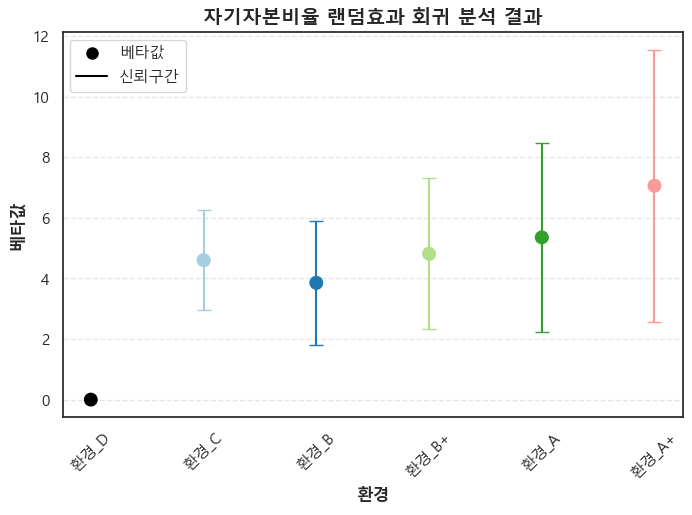

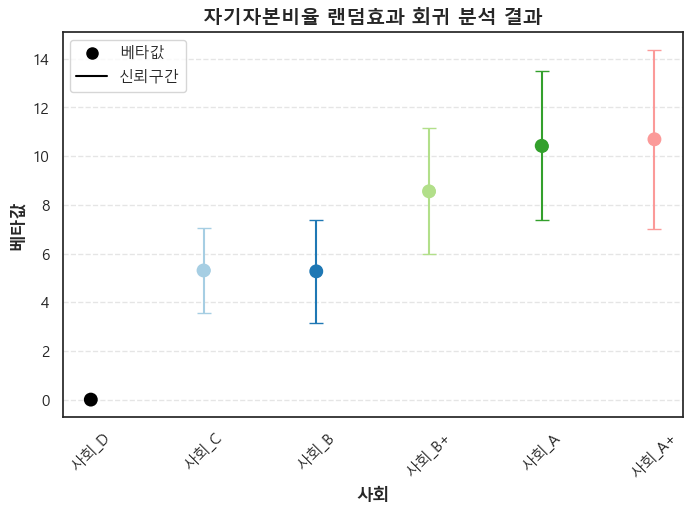

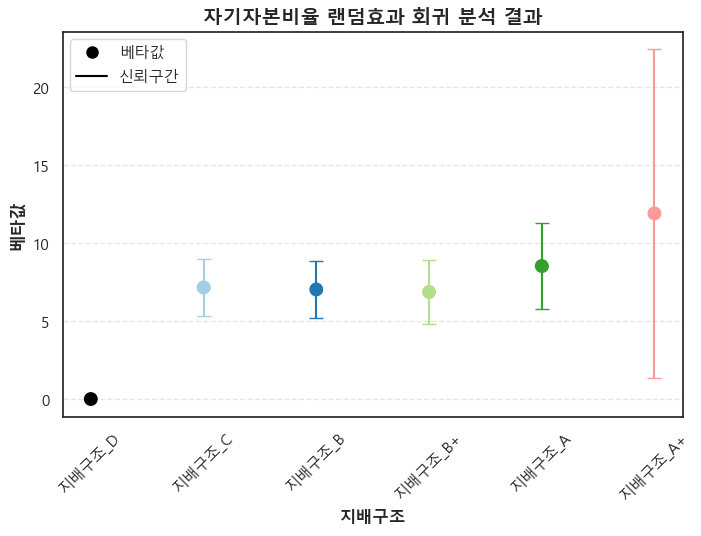

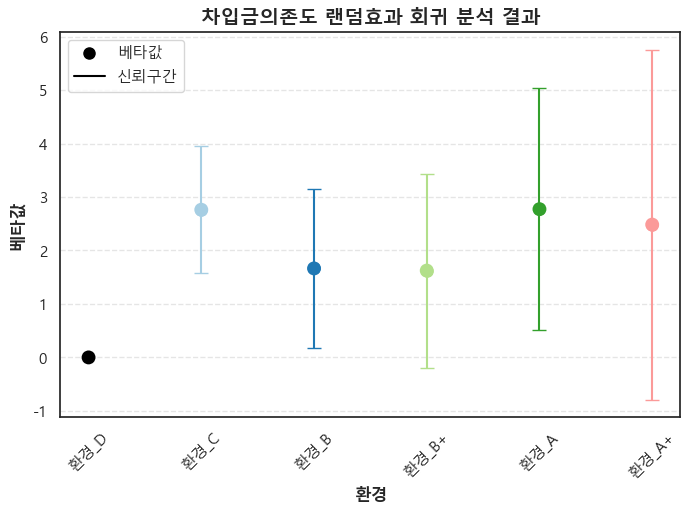

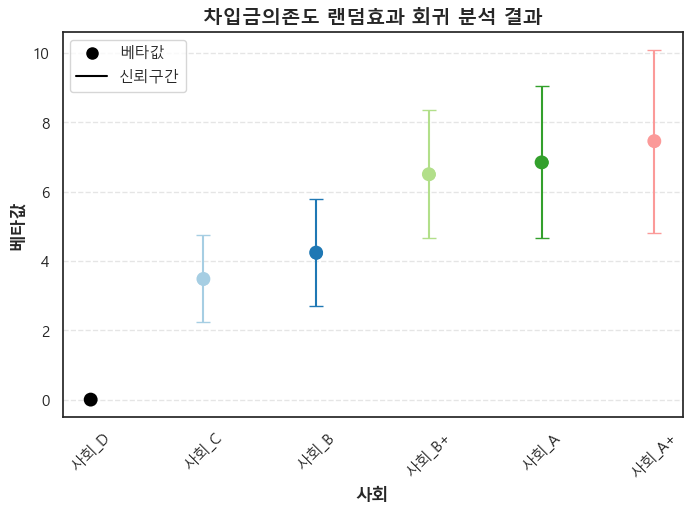

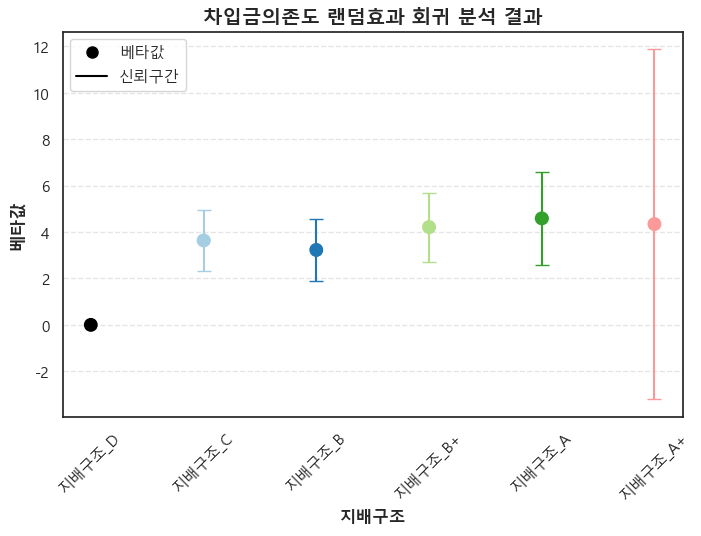

In [31]:
plot_beta_values_beautiful(beta_df, "자기자본비율", model="랜덤", what="환경")
plot_beta_values_beautiful(beta_df, "자기자본비율", model="랜덤", what="사회")
plot_beta_values_beautiful(beta_df, "자기자본비율", model="랜덤", what="지배구조")
plot_beta_values_beautiful(beta_df, "차입금의존도", model="랜덤", what="환경")
plot_beta_values_beautiful(beta_df, "차입금의존도", model="랜덤", what="사회")
plot_beta_values_beautiful(beta_df, "차입금의존도", model="랜덤", what="지배구조")

# ESG 따로/ SHIFT 고정효과 시각화

In [32]:
df = pd.read_csv("IQR1.5_log_scaling_shift.csv")#, index_col=0)
#df = df.drop(columns=['Unnamed: 0'])
df.columns = [re.sub(r"[()% ]", "", col) for col in df.columns]

In [33]:
# 스케일링2

df_transformed = df.copy()

# 패널 데이터 구조 설정 (기업명과 연도를 MultiIndex로 설정)
df_transformed_h = df_transformed.set_index(["Name", "회계년"])

# ESG 등급의 원핫 인코딩 변수 리스트 추출
esg_variables = [col for col in df_transformed_h.columns if col.startswith(("환경_", "사회_", "지배구조_"))]
# 종속변수 리스트
dependent_vars = ["자기자본비율", "차입금의존도", "매출액증가율",
                  "영업이익률", "총자본회전율", "부채상환능력",
                  "log_당좌비율", "ROA당기순이익"]

# 결과 저장을 위한 리스트
results = {}

for dep_var in dependent_vars:
    # 패널 회귀 모델 (고정효과 모델)
    X = df_transformed_h[esg_variables]  # 독립변수: ESG 원핫 인코딩 변수
    X = sm.add_constant(X)
    y = df_transformed_h[dep_var]  # 종속변수

    # 고정효과 모형
    model_fe = PanelOLS(y, X, entity_effects=True, time_effects=True)
    fe_res = model_fe.fit()

    # 랜덤효과 모형
    model_re = RandomEffects(y, X)
    re_res = model_re.fit()

    # 하우스만 검정 수행
    b_diff = fe_res.params - re_res.params
    v_diff = fe_res.cov - re_res.cov
    chi2_stat = b_diff.T @ np.linalg.inv(v_diff) @ b_diff
    p_value = 1 - stats.chi2.cdf(chi2_stat, df=len(b_diff))

    # 선택된 모델 결정
    selected_model = "Fixed Effects" if p_value < 0.05 else "Random Effects"

    # 결과 저장
    results[dep_var] = {"Hausman Test p-value": p_value, "Selected Model": selected_model}

# 결과출력
results_df = pd.DataFrame(results).T
results_df

,Hausman Test p-value,Selected Model
자기자본비율,0.001134,Fixed Effects
차입금의존도,0.140033,Random Effects
매출액증가율,0.0,Fixed Effects
영업이익률,0.000013,Fixed Effects
총자본회전율,0.0,Fixed Effects
부채상환능력,0.075019,Random Effects
log_당좌비율,0.011489,Fixed Effects
ROA당기순이익,0.000304,Fixed Effects


In [34]:
# 패널 데이터 형식으로 변환
df_transformed_pf = df_transformed.set_index(["Name", "회계년"])  # 기업 ID와 연도를 기준으로 패널 데이터 설정

# 종속변수 목록
dependent_vars = ["자기자본비율","매출액증가율", "영업이익률", "총자본회전율", "log_당좌비율", "ROA당기순이익"]

# 독립변수: ESG 등급 (다중공선성 방지를 위해 하나의 등급 제거된 상태여야 함)
independent_vars = [col for col in df_transformed_h.columns if col.startswith(("환경_", "사회_", "지배구조_"))]

# 분석 결과 저장용 리스트
fe_results_list1 = []

for dep_var in dependent_vars:
    # 종속변수와 독립변수 설정
    y = df_transformed_pf[dep_var]
    X = df_transformed_pf[independent_vars]

    # 고정효과 모형 (패널 OLS)
    model_fe = PanelOLS(y,X, entity_effects=True, time_effects=True)
    fe_results = model_fe.fit()

    # 결과 저장
    fe_results_list1.append((dep_var, fe_results))

    # 각 변수별 결과 출력
    print(f"=== {dep_var} 고정효과 모델 결과 ===")
    print(fe_results)
    print("\n" + "=" * 50 + "\n")

# 분석 결과를 데이터프레임으로 정리하여 확인
summary_data = {
    "종속변수": [],
    "R-squared": [],
    "Adj. R-squared": [],
    "F-statistic": [],
    "p-value": []
}

for dep_var, result in fe_results_list1:
    summary_data["종속변수"].append(dep_var)
    summary_data["R-squared"].append(result.rsquared)
    summary_data["Adj. R-squared"].append(result.rsquared_within)
    summary_data["F-statistic"].append(result.f_statistic.stat if result.f_statistic else None)
    summary_data["p-value"].append(result.f_statistic.pval if result.f_statistic else None)

summary_df3 = pd.DataFrame(summary_data)

=== 자기자본비율 고정효과 모델 결과 ===
                          PanelOLS Estimation Summary                           
Dep. Variable:                 자기자본비율   R-squared:                        0.0058
Estimator:                   PanelOLS   R-squared (Between):             -0.0063
No. Observations:                1562   R-squared (Within):               0.0050
Date:                Sun, Feb 16 2025   R-squared (Overall):             -0.0064
Time:                        18:03:02   Log-likelihood                   -4374.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.4009
Entities:                         510   P-value                           0.9792
Avg Obs:                       3.0627   Distribution:                 F(15,1034)
Min Obs:                       1.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             0.4009
  

In [35]:
# ✅ 베타값, 신뢰구간 추출 및 데이터프레임 생성
beta_results = []

for dep_var, result in fe_results_list1:
    for param in independent_vars:
        coef = result.params[param]  # 베타값
        std_err = result.std_errors[param]  # 표준오차
        lower_ci = coef - 1.96 * std_err  # 95% 신뢰구간 하한
        upper_ci = coef + 1.96 * std_err  # 95% 신뢰구간 상한
        
        beta_results.append({
            "종속변수": dep_var,
            "독립변수": param,
            "베타값": coef,
            "Lower CI": lower_ci,
            "Upper CI": upper_ci
        })

# ✅ 데이터프레임 변환
beta_df = pd.DataFrame(beta_results)
beta_df

,종속변수,독립변수,베타값,Lower CI,Upper CI
0,자기자본비율,환경_A,-0.589730,-2.871669,1.692209
1,자기자본비율,환경_A+,0.271095,-2.811586,3.353775
2,자기자본비율,환경_B,-0.118874,-1.677164,1.439416
3,자기자본비율,환경_B+,0.514422,-1.371513,2.400357
4,자기자본비율,환경_C,0.262726,-0.905693,1.431144
...,...,...,...,...,...
85,ROA당기순이익,지배구조_A,0.657483,-0.470341,1.785307
86,ROA당기순이익,지배구조_A+,-0.043570,-2.966911,2.879771
87,ROA당기순이익,지배구조_B,-0.295524,-1.002997,0.411950
88,ROA당기순이익,지배구조_B+,0.081718,-0.770865,0.934300


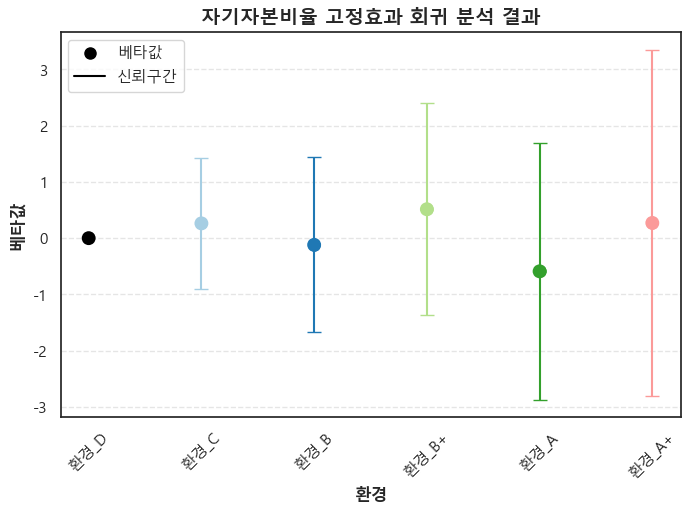

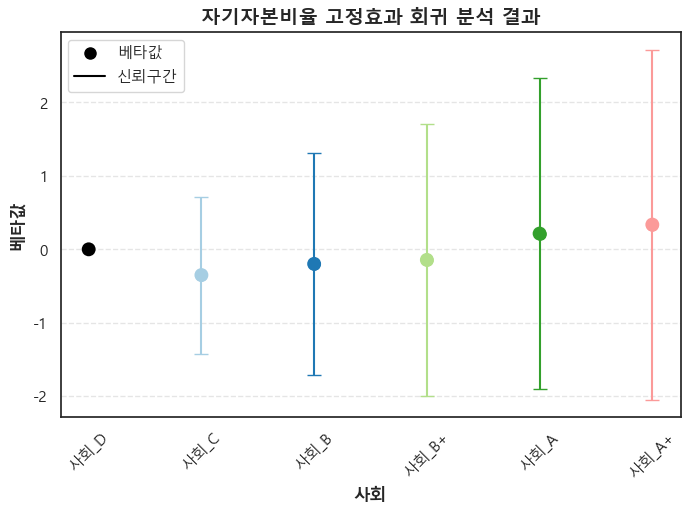

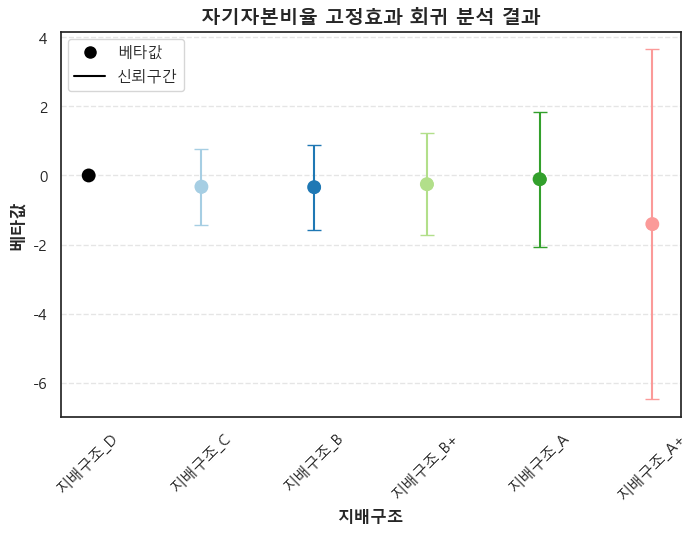

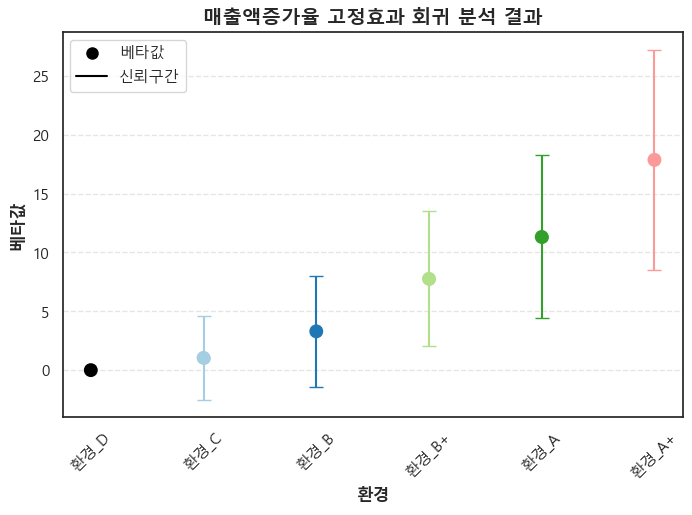

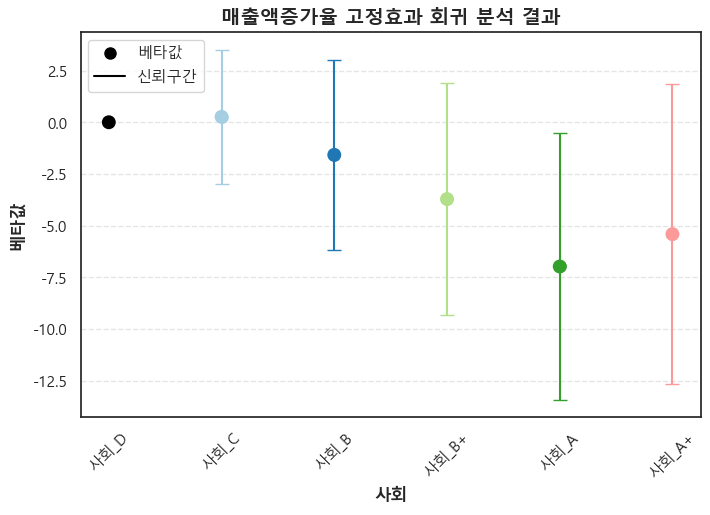

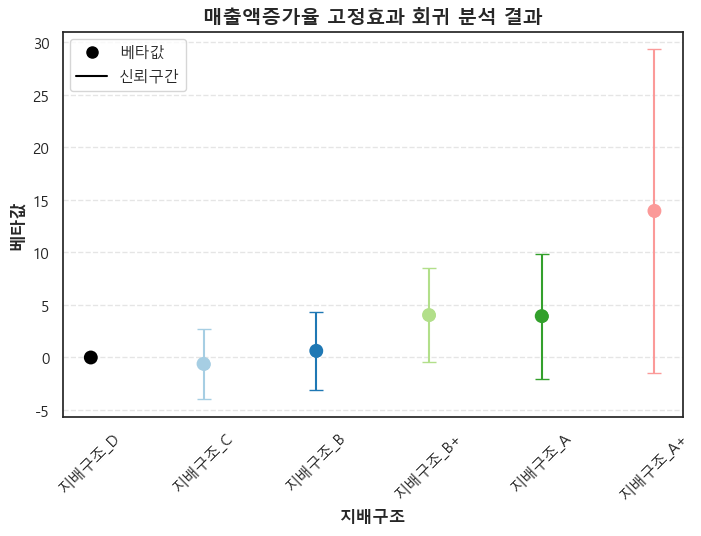

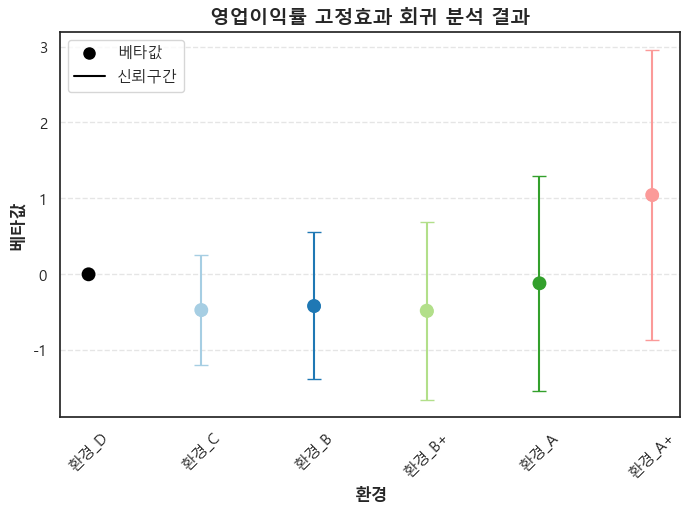

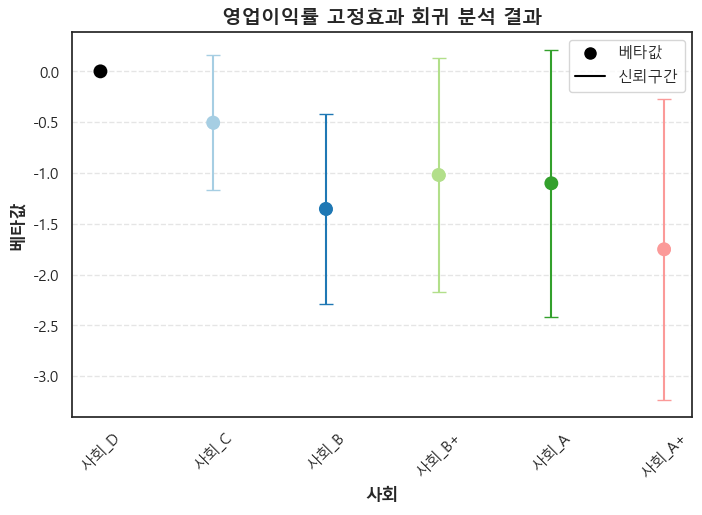

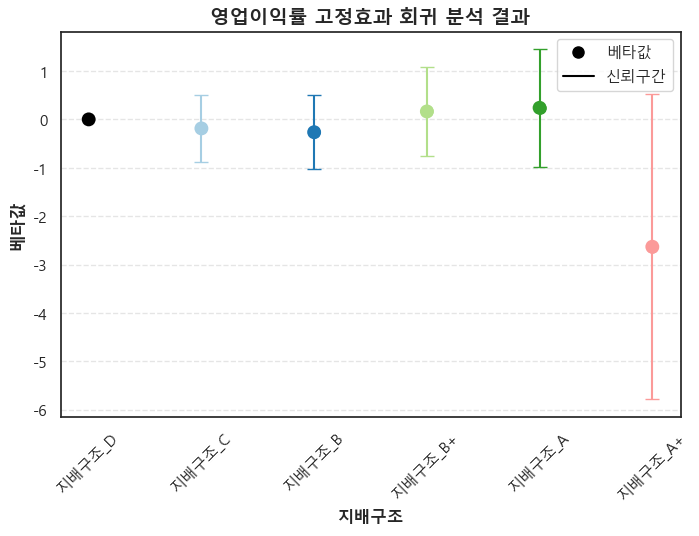

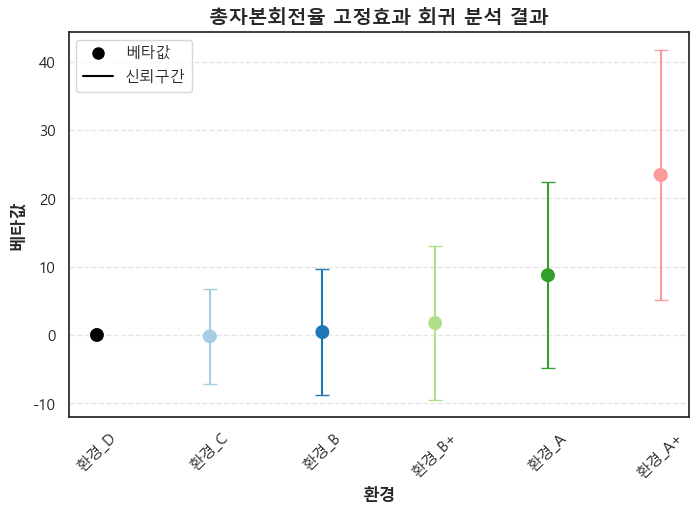

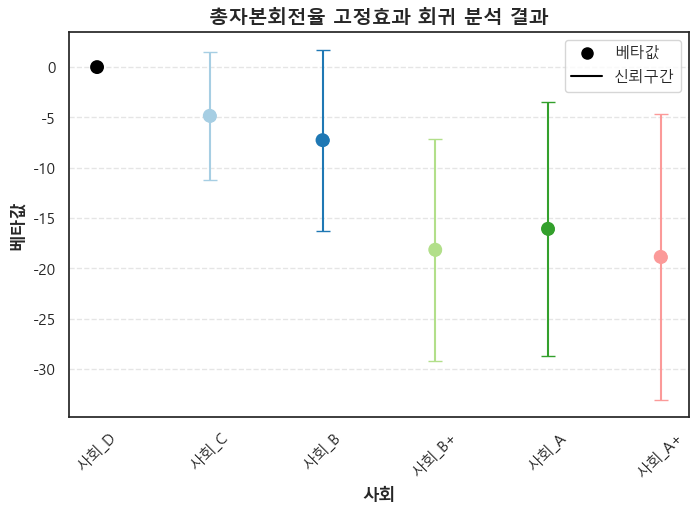

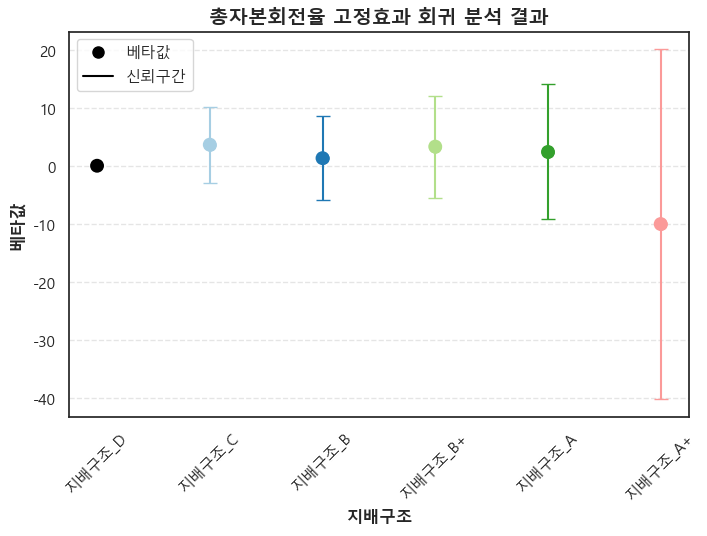

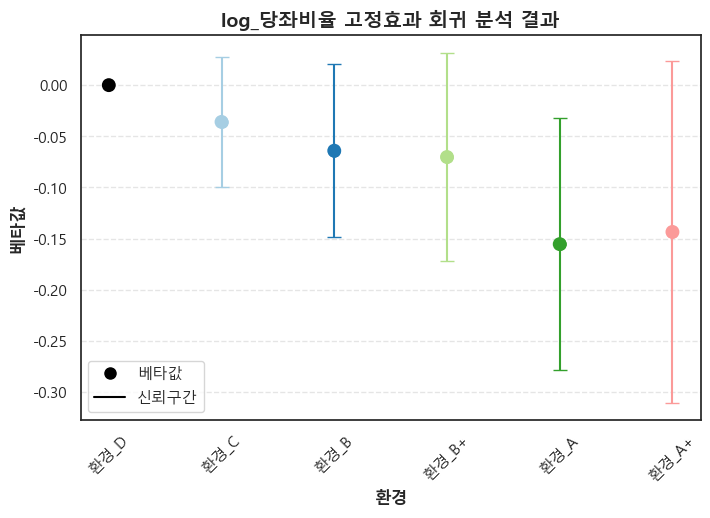

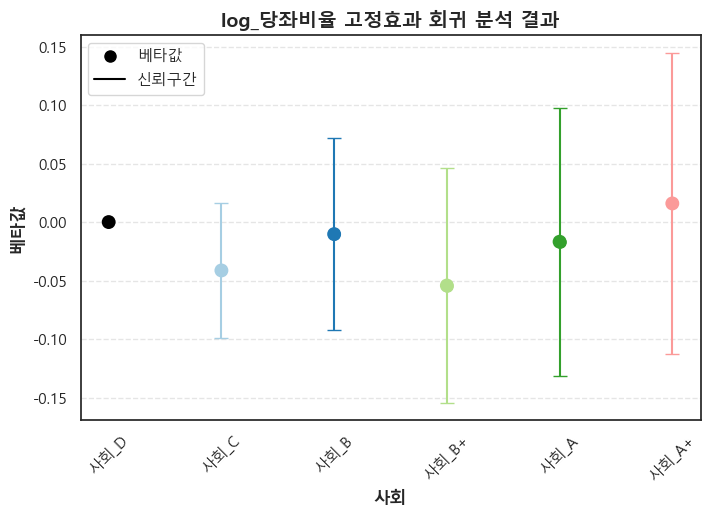

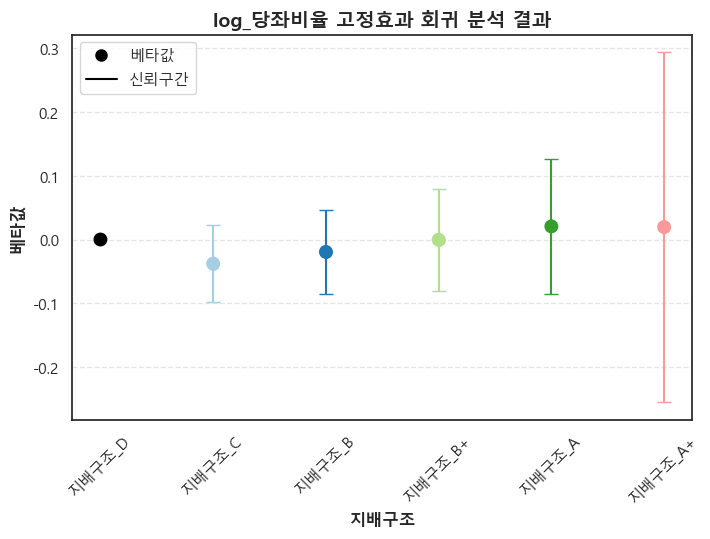

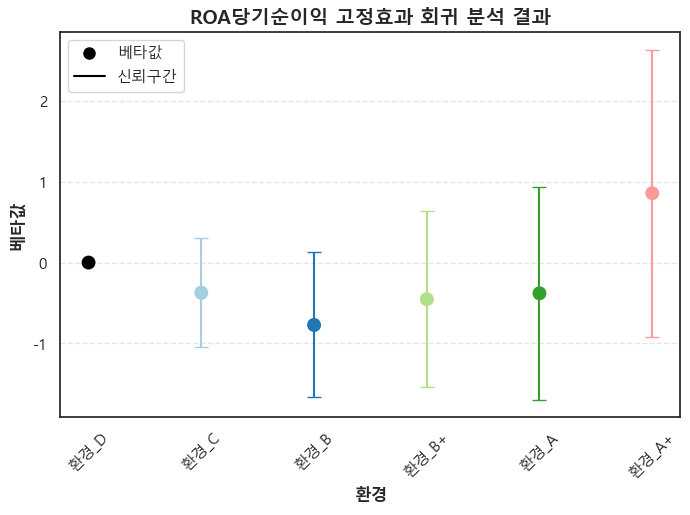

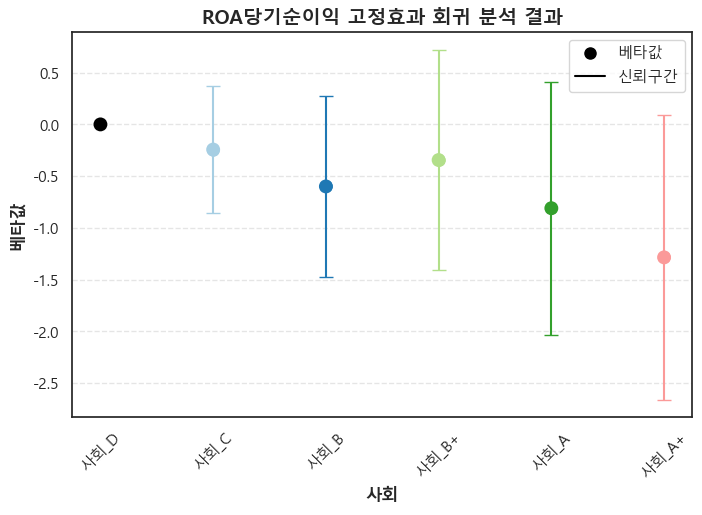

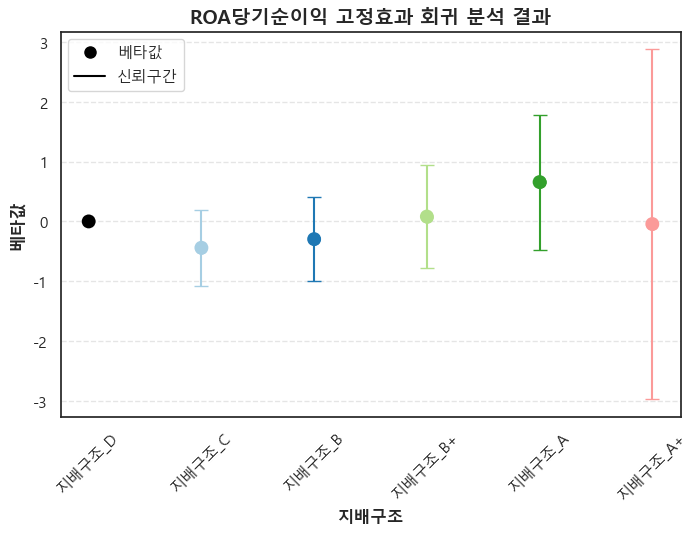

In [36]:
plot_beta_values_beautiful(beta_df, "자기자본비율", model="고정", what="환경")
plot_beta_values_beautiful(beta_df, "자기자본비율", model="고정", what="사회")
plot_beta_values_beautiful(beta_df, "자기자본비율", model="고정", what="지배구조")
plot_beta_values_beautiful(beta_df, "매출액증가율", model="고정", what="환경")
plot_beta_values_beautiful(beta_df, "매출액증가율", model="고정", what="사회")
plot_beta_values_beautiful(beta_df, "매출액증가율", model="고정", what="지배구조")
plot_beta_values_beautiful(beta_df, "영업이익률", model="고정", what="환경")
plot_beta_values_beautiful(beta_df, "영업이익률", model="고정", what="사회")
plot_beta_values_beautiful(beta_df, "영업이익률", model="고정", what="지배구조")
plot_beta_values_beautiful(beta_df, "총자본회전율", model="고정", what="환경")
plot_beta_values_beautiful(beta_df, "총자본회전율", model="고정", what="사회")
plot_beta_values_beautiful(beta_df, "총자본회전율", model="고정", what="지배구조")
plot_beta_values_beautiful(beta_df, "log_당좌비율", model="고정", what="환경")
plot_beta_values_beautiful(beta_df, "log_당좌비율", model="고정", what="사회")
plot_beta_values_beautiful(beta_df, "log_당좌비율", model="고정", what="지배구조")
plot_beta_values_beautiful(beta_df, "ROA당기순이익", model="고정", what="환경")
plot_beta_values_beautiful(beta_df, "ROA당기순이익", model="고정", what="사회")
plot_beta_values_beautiful(beta_df, "ROA당기순이익", model="고정", what="지배구조")

# ESG 따로/Shift 랜덤효과 시각화

In [37]:
# 패널 데이터 형식으로 변환
df_transformed_pf = df_transformed.set_index(["Name", "회계년"])  # 기업 ID와 연도를 기준으로 패널 데이터 설정

# 종속변수 목록 (원하는 변수로 설정)
dependent_vars_re = ["차입금의존도", "부채상환능력"]  # 여기에 원하는 종속변수 입력

# 독립변수: ESG 등급 (다중공선성 방지를 위해 하나의 등급 제거된 상태여야 함)
independent_vars = [col for col in df_transformed_h.columns if col.startswith(("환경_", "사회_", "지배구조_"))]

# 분석 결과 저장용 리스트
re_results_list2 = []

for dep_var in dependent_vars_re:
    # 종속변수와 독립변수 설정
    y = df_transformed_pf[dep_var]
    X = df_transformed_pf[independent_vars]

    # 랜덤효과 모형 (패널 GLS)
    model_re = RandomEffects(y, X)
    re_results = model_re.fit()

    # 결과 저장
    re_results_list2.append((dep_var, re_results))

    # 각 변수별 결과 출력
    print(f"=== {dep_var} 랜덤효과 모델 결과 ===")
    print(re_results)
    print("\n" + "=" * 50 + "\n")

# 분석 결과를 데이터프레임으로 정리하여 확인
summary_data_re = {
    "종속변수": [],
    "R-squared": [],
    "Adj. R-squared": [],
    "F-statistic": [],
    "p-value": []
}

for dep_var, result in re_results_list2:
    summary_data_re["종속변수"].append(dep_var)
    summary_data_re["R-squared"].append(result.rsquared)
    summary_data_re["Adj. R-squared"].append(result.rsquared_within)
    summary_data_re["F-statistic"].append(result.f_statistic.stat if result.f_statistic else None)
    summary_data_re["p-value"].append(result.f_statistic.pval if result.f_statistic else None)

summary_df_re = pd.DataFrame(summary_data_re)

=== 차입금의존도 랜덤효과 모델 결과 ===
                        RandomEffects Estimation Summary                        
Dep. Variable:                 차입금의존도   R-squared:                        0.2024
Estimator:              RandomEffects   R-squared (Between):              0.4778
No. Observations:                1562   R-squared (Within):              -0.1838
Date:                Sun, Feb 16 2025   R-squared (Overall):              0.4776
Time:                        18:03:06   Log-likelihood                   -4911.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      26.168
Entities:                         510   P-value                           0.0000
Avg Obs:                       3.0627   Distribution:                 F(15,1547)
Min Obs:                       1.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             26.168
  

In [38]:
# ✅ 베타값, 신뢰구간 추출 및 데이터프레임 생성
beta_results = []

for dep_var, result in re_results_list2:
    for param in independent_vars:
        coef = result.params[param]  # 베타값
        std_err = result.std_errors[param]  # 표준오차
        lower_ci = coef - 1.96 * std_err  # 95% 신뢰구간 하한
        upper_ci = coef + 1.96 * std_err  # 95% 신뢰구간 상한
        
        beta_results.append({
            "종속변수": dep_var,
            "독립변수": param,
            "베타값": coef,
            "Lower CI": lower_ci,
            "Upper CI": upper_ci
        })

# ✅ 데이터프레임 변환
beta_df = pd.DataFrame(beta_results)
beta_df

,종속변수,독립변수,베타값,Lower CI,Upper CI
0,차입금의존도,환경_A,4.205280,1.993924,6.416636
1,차입금의존도,환경_A+,1.888511,-1.220049,4.997072
2,차입금의존도,환경_B,3.486866,1.868502,5.105230
3,차입금의존도,환경_B+,2.608050,0.730280,4.485820
4,차입금의존도,환경_C,3.655523,2.482338,4.828707
5,차입금의존도,사회_A,7.358200,5.134697,9.581703
6,차입금의존도,사회_A+,7.733503,5.202334,10.264672
7,차입금의존도,사회_B,4.019887,2.388493,5.651281
8,차입금의존도,사회_B+,6.397723,4.446738,8.348708
9,차입금의존도,사회_C,3.079068,1.912129,4.246007


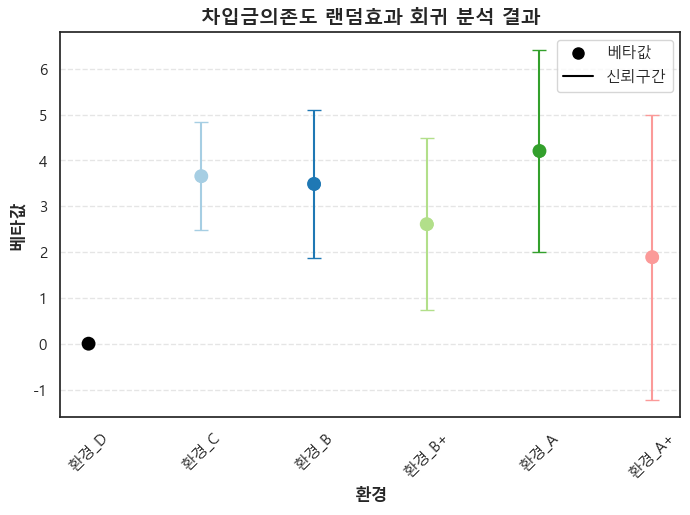

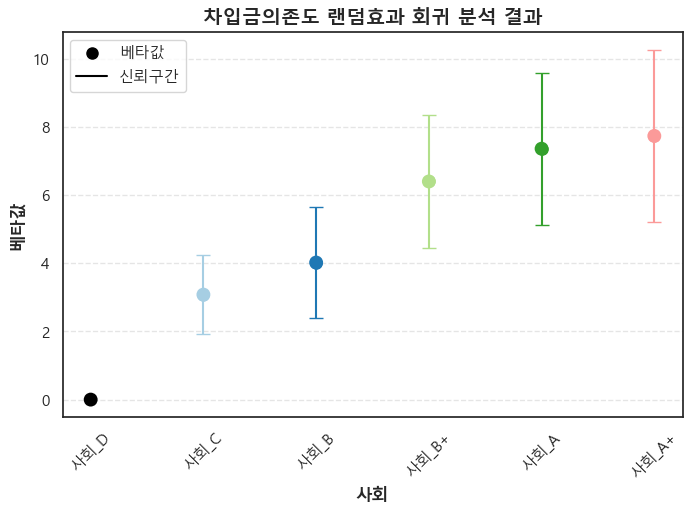

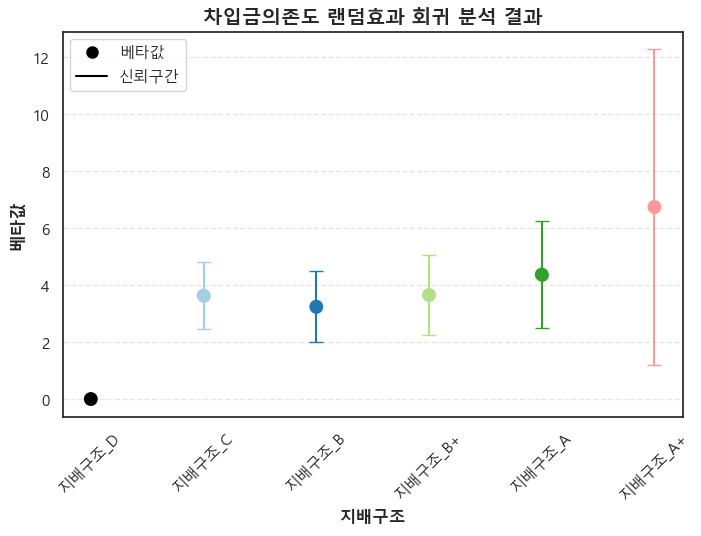

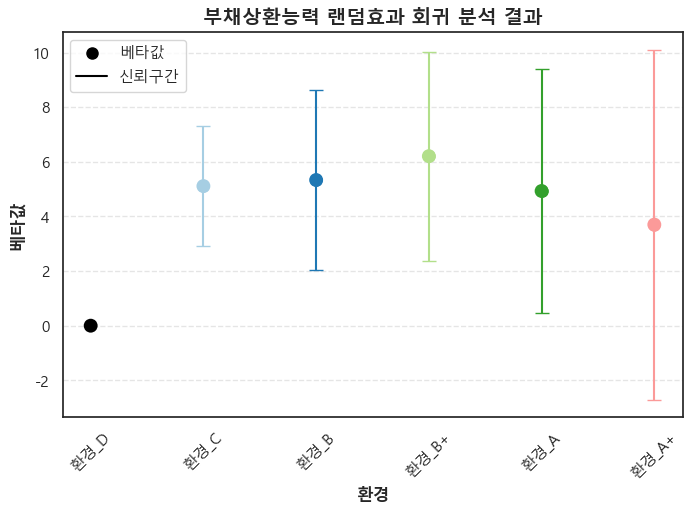

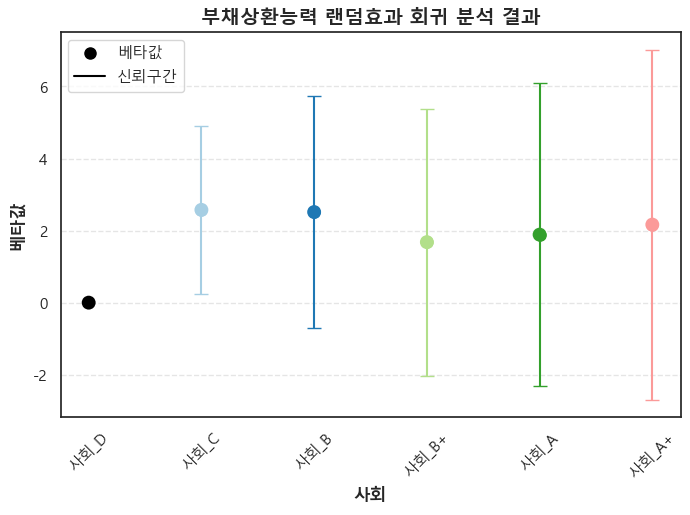

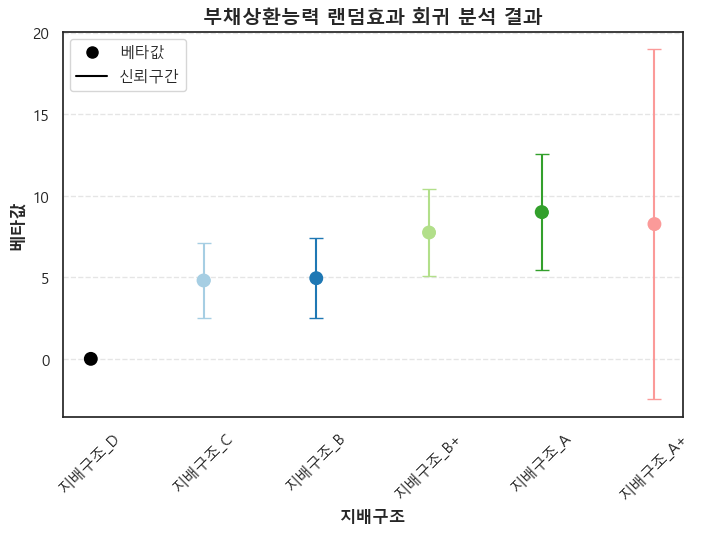

In [39]:
plot_beta_values_beautiful(beta_df, "차입금의존도", model="랜덤", what="환경")
plot_beta_values_beautiful(beta_df, "차입금의존도", model="랜덤", what="사회")
plot_beta_values_beautiful(beta_df, "차입금의존도", model="랜덤", what="지배구조")
plot_beta_values_beautiful(beta_df, "부채상환능력", model="랜덤", what="환경")
plot_beta_values_beautiful(beta_df, "부채상환능력", model="랜덤", what="사회")
plot_beta_values_beautiful(beta_df, "부채상환능력", model="랜덤", what="지배구조")